In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import model
from tqdm import tqdm
from torchvision import datasets
from scipy.stats import norm
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

In [4]:
losses_train = []
losses_val = []
e_list = (0,4,9,49,99,149,199,249,299,349,399,449,499,549,599,649,699,749,799,849,899,949,999,1099,1199)

In [5]:
#Learning parameters
epochs = 1000
batch_size = 128
lr = 0.0002
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
torch.Size([14000,28,28])
val_data = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)
torch.Size([6000,28,28])
# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)

Extracting ../input/data/MNIST/raw/train-images-idx3-ubyte.gz to ../input/data/MNIST/raw


Extracting ../input/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/data/MNIST/raw


Extracting ../input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/data/MNIST/raw




Extracting ../input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
model = model.LinearVAE().to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

LinearVAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)


In [8]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
"""
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [9]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    losses_train.append(train_loss)
    return train_loss

In [10]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
#     inception_score = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                if(epoch in e_list):
                    save_image(both.cpu(), f"drive/MyDrive/VAE_outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    losses_val.append(val_loss)
    return val_loss

In [11]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1 of 1000


469it [00:07, 66.34it/s]                         
79it [00:01, 66.63it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.75it/s]

Train Loss: 209.7679
Val Loss: 176.4753
Epoch 2 of 1000


469it [00:06, 68.08it/s]                         
79it [00:00, 91.02it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.42it/s]

Train Loss: 172.5111
Val Loss: 168.4634
Epoch 3 of 1000


469it [00:06, 68.35it/s]                         
79it [00:00, 91.51it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.67it/s]

Train Loss: 166.4625
Val Loss: 163.9723
Epoch 4 of 1000


469it [00:06, 68.69it/s]                         
79it [00:00, 94.92it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.48it/s]

Train Loss: 162.9490
Val Loss: 161.1164
Epoch 5 of 1000


469it [00:06, 68.10it/s]                         
79it [00:01, 72.70it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.81it/s]

Train Loss: 160.5067
Val Loss: 159.1358
Epoch 6 of 1000


469it [00:06, 68.63it/s]                         
79it [00:00, 94.76it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.39it/s]

Train Loss: 158.6769
Val Loss: 157.3727
Epoch 7 of 1000


469it [00:06, 69.23it/s]                         
79it [00:00, 94.73it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.55it/s]

Train Loss: 157.0963
Val Loss: 155.9996
Epoch 8 of 1000


469it [00:06, 70.45it/s]                         
79it [00:00, 94.90it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.15it/s]

Train Loss: 155.6008
Val Loss: 154.7151
Epoch 9 of 1000


469it [00:06, 70.73it/s]                         
79it [00:00, 97.10it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 69.70it/s]

Train Loss: 154.2615
Val Loss: 153.6719
Epoch 10 of 1000


469it [00:06, 71.09it/s]                         
79it [00:01, 74.99it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.32it/s]

Train Loss: 153.1675
Val Loss: 152.8205
Epoch 11 of 1000


469it [00:06, 71.15it/s]                         
79it [00:00, 96.98it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.57it/s]

Train Loss: 152.1575
Val Loss: 152.1784
Epoch 12 of 1000


469it [00:06, 70.10it/s]                         
79it [00:00, 96.02it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.19it/s]

Train Loss: 151.2859
Val Loss: 151.4188
Epoch 13 of 1000


469it [00:06, 70.18it/s]                         
79it [00:00, 94.26it/s]                        
  1%|▏         | 6/468 [00:00<00:08, 57.21it/s]

Train Loss: 150.4626
Val Loss: 150.5970
Epoch 14 of 1000


469it [00:06, 69.48it/s]                         
79it [00:00, 96.46it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 64.95it/s]

Train Loss: 149.7287
Val Loss: 150.4012
Epoch 15 of 1000


469it [00:06, 68.93it/s]                         
79it [00:00, 96.16it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 62.26it/s]

Train Loss: 148.9775
Val Loss: 149.7817
Epoch 16 of 1000


469it [00:06, 69.78it/s]                         
79it [00:00, 94.62it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.46it/s]

Train Loss: 148.3433
Val Loss: 149.0066
Epoch 17 of 1000


469it [00:06, 70.78it/s]                         
79it [00:00, 95.84it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.85it/s]

Train Loss: 147.7435
Val Loss: 148.5806
Epoch 18 of 1000


469it [00:06, 71.60it/s]                         
79it [00:00, 95.12it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.03it/s]

Train Loss: 147.1249
Val Loss: 148.1267
Epoch 19 of 1000


469it [00:06, 70.59it/s]                         
79it [00:00, 95.91it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.48it/s]

Train Loss: 146.6710
Val Loss: 147.8674
Epoch 20 of 1000


469it [00:06, 70.65it/s]                         
79it [00:00, 96.80it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.20it/s]

Train Loss: 146.1762
Val Loss: 147.7910
Epoch 21 of 1000


469it [00:06, 70.85it/s]                         
79it [00:00, 95.13it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.64it/s]

Train Loss: 145.6834
Val Loss: 147.2814
Epoch 22 of 1000


469it [00:06, 71.26it/s]                         
79it [00:00, 98.35it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.27it/s]

Train Loss: 145.3020
Val Loss: 147.1860
Epoch 23 of 1000


469it [00:06, 70.72it/s]                         
79it [00:00, 94.15it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.27it/s]

Train Loss: 144.8884
Val Loss: 146.8223
Epoch 24 of 1000


469it [00:06, 70.70it/s]
79it [00:00, 97.86it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.37it/s]

Train Loss: 144.5185
Val Loss: 146.6286
Epoch 25 of 1000


469it [00:06, 70.82it/s]                         
79it [00:00, 98.58it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.55it/s]

Train Loss: 144.2067
Val Loss: 146.3948
Epoch 26 of 1000


469it [00:06, 71.05it/s]
79it [00:00, 98.52it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.12it/s]

Train Loss: 143.8733
Val Loss: 145.8382
Epoch 27 of 1000


469it [00:06, 71.14it/s]
79it [00:00, 98.20it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.64it/s]

Train Loss: 143.5119
Val Loss: 146.0647
Epoch 28 of 1000


469it [00:06, 69.49it/s]
79it [00:00, 93.48it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.48it/s]

Train Loss: 143.2645
Val Loss: 145.4864
Epoch 29 of 1000


469it [00:06, 68.15it/s]                         
79it [00:00, 97.60it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.10it/s]

Train Loss: 142.9369
Val Loss: 145.6244
Epoch 30 of 1000


469it [00:06, 70.76it/s]
79it [00:00, 97.60it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.71it/s]

Train Loss: 142.7915
Val Loss: 145.3870
Epoch 31 of 1000


469it [00:06, 71.42it/s]                         
79it [00:00, 96.83it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.68it/s]

Train Loss: 142.4985
Val Loss: 145.2631
Epoch 32 of 1000


469it [00:06, 70.60it/s]                         
79it [00:00, 97.54it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.42it/s]

Train Loss: 142.2641
Val Loss: 144.9440
Epoch 33 of 1000


469it [00:06, 70.79it/s]                         
79it [00:00, 93.33it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.45it/s]

Train Loss: 142.0351
Val Loss: 144.9169
Epoch 34 of 1000


469it [00:06, 69.49it/s]                         
79it [00:00, 93.53it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.85it/s]

Train Loss: 141.8031
Val Loss: 145.0314
Epoch 35 of 1000


469it [00:06, 68.94it/s]                         
79it [00:00, 95.44it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.43it/s]

Train Loss: 141.6211
Val Loss: 144.6110
Epoch 36 of 1000


469it [00:06, 71.29it/s]
79it [00:00, 96.47it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.70it/s]

Train Loss: 141.4216
Val Loss: 144.6997
Epoch 37 of 1000


469it [00:06, 70.79it/s]                         
79it [00:00, 97.78it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.21it/s]

Train Loss: 141.2279
Val Loss: 144.6797
Epoch 38 of 1000


469it [00:06, 70.56it/s]                         
79it [00:00, 95.05it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.51it/s]

Train Loss: 141.0954
Val Loss: 144.5473
Epoch 39 of 1000


469it [00:06, 70.37it/s]                         
79it [00:00, 96.24it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.93it/s]

Train Loss: 140.9391
Val Loss: 144.3364
Epoch 40 of 1000


469it [00:06, 70.10it/s]                         
79it [00:00, 96.80it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.12it/s]

Train Loss: 140.7513
Val Loss: 144.2997
Epoch 41 of 1000


469it [00:06, 69.44it/s]                         
79it [00:00, 93.22it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.31it/s]

Train Loss: 140.5543
Val Loss: 144.4171
Epoch 42 of 1000


469it [00:06, 71.21it/s]                         
79it [00:00, 100.45it/s]                       
  1%|▏         | 6/468 [00:00<00:07, 59.44it/s]

Train Loss: 140.4153
Val Loss: 144.3267
Epoch 43 of 1000


469it [00:06, 71.11it/s]                         
79it [00:00, 95.53it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.73it/s]

Train Loss: 140.3041
Val Loss: 144.1667
Epoch 44 of 1000


469it [00:06, 70.92it/s]
79it [00:00, 97.84it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 69.27it/s]

Train Loss: 140.0934
Val Loss: 144.0831
Epoch 45 of 1000


469it [00:06, 70.93it/s]                         
79it [00:00, 98.94it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.68it/s]

Train Loss: 139.9592
Val Loss: 143.7691
Epoch 46 of 1000


469it [00:06, 71.16it/s]                         
79it [00:00, 97.03it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.40it/s]

Train Loss: 139.8058
Val Loss: 143.6188
Epoch 47 of 1000


469it [00:06, 71.47it/s]
79it [00:00, 98.08it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 67.07it/s]

Train Loss: 139.7492
Val Loss: 143.9298
Epoch 48 of 1000


469it [00:06, 71.19it/s]                         
79it [00:00, 94.63it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.26it/s]

Train Loss: 139.5428
Val Loss: 143.8302
Epoch 49 of 1000


469it [00:06, 70.74it/s]                         
79it [00:00, 97.35it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.79it/s]

Train Loss: 139.4942
Val Loss: 143.4758
Epoch 50 of 1000


469it [00:06, 70.74it/s]                         
79it [00:01, 73.33it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.72it/s]

Train Loss: 139.3084
Val Loss: 144.3151
Epoch 51 of 1000


469it [00:06, 70.77it/s]                         
79it [00:00, 97.21it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.74it/s]

Train Loss: 139.1749
Val Loss: 143.6342
Epoch 52 of 1000


469it [00:06, 72.57it/s]
79it [00:00, 98.12it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 62.69it/s]

Train Loss: 139.0174
Val Loss: 143.5426
Epoch 53 of 1000


469it [00:06, 71.78it/s]
79it [00:00, 96.48it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.92it/s]

Train Loss: 138.9486
Val Loss: 143.5212
Epoch 54 of 1000


469it [00:06, 70.81it/s]                         
79it [00:00, 97.89it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.56it/s]

Train Loss: 138.8787
Val Loss: 143.3359
Epoch 55 of 1000


469it [00:06, 69.78it/s]
79it [00:00, 94.45it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.24it/s]

Train Loss: 138.7748
Val Loss: 143.3586
Epoch 56 of 1000


469it [00:06, 69.42it/s]                         
79it [00:00, 96.31it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.28it/s]

Train Loss: 138.6368
Val Loss: 143.2692
Epoch 57 of 1000


469it [00:06, 68.45it/s]                         
79it [00:00, 95.90it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.27it/s]

Train Loss: 138.5353
Val Loss: 143.2986
Epoch 58 of 1000


469it [00:06, 70.80it/s]                         
79it [00:00, 96.06it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 60.46it/s]

Train Loss: 138.4213
Val Loss: 143.1638
Epoch 59 of 1000


469it [00:06, 70.05it/s]                         
79it [00:00, 94.00it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.95it/s]

Train Loss: 138.3134
Val Loss: 143.0923
Epoch 60 of 1000


469it [00:06, 70.33it/s]                         
79it [00:00, 95.04it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.86it/s]

Train Loss: 138.2312
Val Loss: 143.1521
Epoch 61 of 1000


469it [00:06, 69.43it/s]                         
79it [00:00, 93.65it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.94it/s]

Train Loss: 138.1408
Val Loss: 142.8791
Epoch 62 of 1000


469it [00:06, 69.45it/s]
79it [00:00, 94.13it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.01it/s]

Train Loss: 138.0738
Val Loss: 142.7979
Epoch 63 of 1000


469it [00:06, 69.42it/s]                         
79it [00:00, 97.09it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.98it/s]

Train Loss: 137.9640
Val Loss: 143.2947
Epoch 64 of 1000


469it [00:06, 69.87it/s]                         
79it [00:00, 94.62it/s]
  2%|▏         | 8/468 [00:00<00:06, 73.07it/s]

Train Loss: 137.8188
Val Loss: 142.8542
Epoch 65 of 1000


469it [00:06, 71.00it/s]                         
79it [00:00, 97.14it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.55it/s]

Train Loss: 137.7479
Val Loss: 143.0089
Epoch 66 of 1000


469it [00:06, 70.35it/s]                         
79it [00:00, 95.59it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 65.97it/s]

Train Loss: 137.7105
Val Loss: 143.0591
Epoch 67 of 1000


469it [00:06, 70.83it/s]                         
79it [00:00, 97.01it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.45it/s]

Train Loss: 137.6257
Val Loss: 142.8756
Epoch 68 of 1000


469it [00:06, 71.54it/s]
79it [00:00, 97.43it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.73it/s]

Train Loss: 137.5068
Val Loss: 142.7543
Epoch 69 of 1000


469it [00:06, 71.09it/s]                         
79it [00:00, 93.54it/s]                        
  1%|▏         | 6/468 [00:00<00:07, 58.20it/s]

Train Loss: 137.4447
Val Loss: 142.7250
Epoch 70 of 1000


469it [00:06, 67.92it/s]                         
79it [00:00, 93.12it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.74it/s]

Train Loss: 137.3599
Val Loss: 142.8918
Epoch 71 of 1000


469it [00:06, 69.60it/s]                         
79it [00:00, 97.31it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.67it/s]

Train Loss: 137.2533
Val Loss: 142.5897
Epoch 72 of 1000


469it [00:06, 71.16it/s]
79it [00:00, 97.37it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.41it/s]

Train Loss: 137.2015
Val Loss: 142.6258
Epoch 73 of 1000


469it [00:06, 71.36it/s]
79it [00:00, 97.02it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.18it/s]

Train Loss: 137.1408
Val Loss: 142.8400
Epoch 74 of 1000


469it [00:06, 70.55it/s]                         
79it [00:00, 96.68it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 69.76it/s]

Train Loss: 137.0650
Val Loss: 142.6092
Epoch 75 of 1000


469it [00:06, 70.94it/s]                         
79it [00:00, 97.03it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.74it/s]

Train Loss: 136.9985
Val Loss: 142.5693
Epoch 76 of 1000


469it [00:06, 70.74it/s]                         
79it [00:00, 95.67it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.68it/s]

Train Loss: 136.9321
Val Loss: 142.7371
Epoch 77 of 1000


469it [00:06, 70.15it/s]                         
79it [00:00, 96.22it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 64.87it/s]

Train Loss: 136.8330
Val Loss: 142.7737
Epoch 78 of 1000


469it [00:06, 71.40it/s]                         
79it [00:00, 99.25it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.09it/s]

Train Loss: 136.7475
Val Loss: 142.4179
Epoch 79 of 1000


469it [00:06, 70.04it/s]                         
79it [00:00, 95.33it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 69.76it/s]

Train Loss: 136.7081
Val Loss: 142.6278
Epoch 80 of 1000


469it [00:06, 71.53it/s]                         
79it [00:00, 95.43it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.73it/s]

Train Loss: 136.6720
Val Loss: 142.4607
Epoch 81 of 1000


469it [00:06, 71.73it/s]
79it [00:00, 98.49it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.77it/s]

Train Loss: 136.5453
Val Loss: 142.3532
Epoch 82 of 1000


469it [00:06, 71.60it/s]
79it [00:00, 97.50it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.90it/s]

Train Loss: 136.5843
Val Loss: 142.5527
Epoch 83 of 1000


469it [00:06, 71.75it/s]                         
79it [00:00, 98.39it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.91it/s]

Train Loss: 136.4075
Val Loss: 142.4617
Epoch 84 of 1000


469it [00:06, 72.42it/s]                         
79it [00:00, 96.90it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.60it/s]

Train Loss: 136.3996
Val Loss: 142.5290
Epoch 85 of 1000


469it [00:06, 72.23it/s]                         
79it [00:00, 98.32it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.38it/s]

Train Loss: 136.2849
Val Loss: 142.3489
Epoch 86 of 1000


469it [00:06, 72.29it/s]                         
79it [00:00, 100.85it/s]                       
  1%|▏         | 7/468 [00:00<00:06, 67.60it/s]

Train Loss: 136.2252
Val Loss: 142.3917
Epoch 87 of 1000


469it [00:06, 72.04it/s]                         
79it [00:00, 98.27it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.93it/s]

Train Loss: 136.2528
Val Loss: 142.5049
Epoch 88 of 1000


469it [00:06, 71.06it/s]                         
79it [00:00, 97.21it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.93it/s]

Train Loss: 136.2452
Val Loss: 142.5341
Epoch 89 of 1000


469it [00:06, 71.39it/s]                         
79it [00:00, 98.72it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.07it/s]

Train Loss: 136.0502
Val Loss: 142.3197
Epoch 90 of 1000


469it [00:06, 72.42it/s]
79it [00:00, 99.30it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.43it/s]

Train Loss: 135.9676
Val Loss: 142.1615
Epoch 91 of 1000


469it [00:06, 72.11it/s]                         
79it [00:00, 98.86it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.78it/s]

Train Loss: 135.9452
Val Loss: 142.4060
Epoch 92 of 1000


469it [00:06, 72.46it/s]                         
79it [00:00, 101.83it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 68.82it/s]

Train Loss: 135.9144
Val Loss: 142.4408
Epoch 93 of 1000


469it [00:06, 72.60it/s]                         
79it [00:00, 98.75it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.52it/s]

Train Loss: 135.8363
Val Loss: 142.2287
Epoch 94 of 1000


469it [00:06, 72.21it/s]
79it [00:00, 97.85it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.47it/s]

Train Loss: 135.8196
Val Loss: 142.6625
Epoch 95 of 1000


469it [00:06, 72.51it/s]                         
79it [00:00, 99.59it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.35it/s]

Train Loss: 135.7448
Val Loss: 142.0546
Epoch 96 of 1000


469it [00:06, 72.59it/s]                         
79it [00:00, 99.76it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.45it/s]

Train Loss: 135.6998
Val Loss: 142.2650
Epoch 97 of 1000


469it [00:06, 71.67it/s]                         
79it [00:00, 97.50it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.30it/s]

Train Loss: 135.6268
Val Loss: 142.5710
Epoch 98 of 1000


469it [00:06, 72.46it/s]
79it [00:00, 99.11it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.07it/s]

Train Loss: 135.5720
Val Loss: 142.3427
Epoch 99 of 1000


469it [00:06, 72.03it/s]
79it [00:00, 98.80it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.40it/s]

Train Loss: 135.5279
Val Loss: 142.1136
Epoch 100 of 1000


469it [00:06, 72.79it/s]
79it [00:01, 73.93it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.90it/s]

Train Loss: 135.5372
Val Loss: 142.5009
Epoch 101 of 1000


469it [00:06, 72.40it/s]
79it [00:00, 99.40it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.46it/s]

Train Loss: 135.5230
Val Loss: 142.0037
Epoch 102 of 1000


469it [00:06, 72.63it/s]                         
79it [00:00, 100.59it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.97it/s]

Train Loss: 135.4271
Val Loss: 142.0236
Epoch 103 of 1000


469it [00:06, 72.63it/s]                         
79it [00:00, 100.42it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.56it/s]

Train Loss: 135.3486
Val Loss: 142.0243
Epoch 104 of 1000


469it [00:06, 72.21it/s]
79it [00:00, 99.15it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.37it/s]

Train Loss: 135.2519
Val Loss: 142.0673
Epoch 105 of 1000


469it [00:06, 72.43it/s]                         
79it [00:00, 99.25it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.60it/s]

Train Loss: 135.1757
Val Loss: 142.1816
Epoch 106 of 1000


469it [00:06, 72.43it/s]
79it [00:00, 100.41it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.34it/s]

Train Loss: 135.1704
Val Loss: 142.1644
Epoch 107 of 1000


469it [00:06, 72.84it/s]                         
79it [00:00, 100.68it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 71.09it/s]

Train Loss: 135.1774
Val Loss: 142.2170
Epoch 108 of 1000


469it [00:06, 72.75it/s]                         
79it [00:00, 97.55it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.57it/s]

Train Loss: 135.0618
Val Loss: 142.0339
Epoch 109 of 1000


469it [00:06, 72.87it/s]                         
79it [00:00, 98.71it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.50it/s]

Train Loss: 135.0115
Val Loss: 142.3332
Epoch 110 of 1000


469it [00:06, 71.60it/s]
79it [00:00, 98.63it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.65it/s]

Train Loss: 135.2300
Val Loss: 142.1356
Epoch 111 of 1000


469it [00:06, 72.61it/s]                         
79it [00:00, 97.74it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.22it/s]

Train Loss: 135.0421
Val Loss: 142.2021
Epoch 112 of 1000


469it [00:06, 69.58it/s]                         
79it [00:00, 97.34it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.35it/s]

Train Loss: 134.9733
Val Loss: 141.9800
Epoch 113 of 1000


469it [00:06, 70.73it/s]
79it [00:00, 99.20it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.78it/s]

Train Loss: 134.9020
Val Loss: 142.1963
Epoch 114 of 1000


469it [00:06, 71.81it/s]                         
79it [00:00, 99.31it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.13it/s]

Train Loss: 134.7904
Val Loss: 142.1168
Epoch 115 of 1000


469it [00:06, 72.82it/s]
79it [00:00, 97.90it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.72it/s]

Train Loss: 134.7456
Val Loss: 142.3119
Epoch 116 of 1000


469it [00:06, 72.03it/s]
79it [00:00, 99.48it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.60it/s]

Train Loss: 134.7398
Val Loss: 142.5881
Epoch 117 of 1000


469it [00:06, 72.13it/s]                         
79it [00:00, 100.11it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 71.26it/s]

Train Loss: 134.7233
Val Loss: 142.1114
Epoch 118 of 1000


469it [00:06, 72.28it/s]                         
79it [00:00, 97.20it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.32it/s]

Train Loss: 134.7308
Val Loss: 142.2636
Epoch 119 of 1000


469it [00:06, 72.66it/s]                         
79it [00:00, 99.03it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.68it/s]

Train Loss: 134.7354
Val Loss: 142.0239
Epoch 120 of 1000


469it [00:06, 72.29it/s]
79it [00:00, 98.90it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.34it/s]

Train Loss: 134.5575
Val Loss: 142.0007
Epoch 121 of 1000


469it [00:06, 71.32it/s]                         
79it [00:00, 100.10it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 70.87it/s]

Train Loss: 134.5089
Val Loss: 142.0645
Epoch 122 of 1000


469it [00:06, 72.86it/s]                         
79it [00:00, 99.03it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.04it/s]

Train Loss: 134.4930
Val Loss: 142.3360
Epoch 123 of 1000


469it [00:06, 72.74it/s]                         
79it [00:00, 99.85it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.69it/s]

Train Loss: 134.4313
Val Loss: 142.0330
Epoch 124 of 1000


469it [00:06, 73.11it/s]                         
79it [00:00, 99.90it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.36it/s]

Train Loss: 134.3923
Val Loss: 141.9716
Epoch 125 of 1000


469it [00:06, 73.62it/s]                         
79it [00:00, 100.46it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.47it/s]

Train Loss: 134.3503
Val Loss: 142.1469
Epoch 126 of 1000


469it [00:06, 72.99it/s]                         
79it [00:00, 97.24it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.38it/s]

Train Loss: 134.3197
Val Loss: 142.1837
Epoch 127 of 1000


469it [00:06, 73.03it/s]                         
79it [00:00, 99.88it/s]                         
  2%|▏         | 8/468 [00:00<00:06, 73.57it/s]

Train Loss: 134.3617
Val Loss: 142.2483
Epoch 128 of 1000


469it [00:06, 73.08it/s]                         
79it [00:00, 99.85it/s]                         
  1%|▏         | 7/468 [00:00<00:07, 64.92it/s]

Train Loss: 134.2495
Val Loss: 142.1432
Epoch 129 of 1000


469it [00:06, 73.28it/s]                         
79it [00:00, 98.38it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.87it/s]

Train Loss: 134.1741
Val Loss: 141.9170
Epoch 130 of 1000


469it [00:06, 72.63it/s]                         
79it [00:00, 100.58it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.50it/s]

Train Loss: 134.1293
Val Loss: 142.3189
Epoch 131 of 1000


469it [00:06, 72.99it/s]                         
79it [00:00, 99.84it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.75it/s]

Train Loss: 134.1397
Val Loss: 142.3537
Epoch 132 of 1000


469it [00:06, 72.16it/s]                         
79it [00:00, 100.08it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 71.60it/s]

Train Loss: 134.1062
Val Loss: 142.4165
Epoch 133 of 1000


469it [00:06, 73.33it/s]                         
79it [00:00, 101.12it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.12it/s]

Train Loss: 134.1647
Val Loss: 142.4125
Epoch 134 of 1000


469it [00:06, 73.89it/s]                         
79it [00:00, 101.13it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.85it/s]

Train Loss: 134.0505
Val Loss: 142.2224
Epoch 135 of 1000


469it [00:06, 73.64it/s]                         
79it [00:00, 101.62it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.91it/s]

Train Loss: 133.9837
Val Loss: 142.4103
Epoch 136 of 1000


469it [00:06, 73.37it/s]                         
79it [00:00, 100.55it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.80it/s]

Train Loss: 133.9608
Val Loss: 142.2063
Epoch 137 of 1000


469it [00:06, 73.84it/s]                         
79it [00:00, 100.97it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.25it/s]

Train Loss: 133.9582
Val Loss: 142.2396
Epoch 138 of 1000


469it [00:06, 72.69it/s]                         
79it [00:00, 98.22it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.85it/s]

Train Loss: 133.9271
Val Loss: 142.2468
Epoch 139 of 1000


469it [00:06, 73.84it/s]                         
79it [00:00, 101.50it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.60it/s]

Train Loss: 133.8513
Val Loss: 142.2809
Epoch 140 of 1000


469it [00:06, 72.67it/s]
79it [00:00, 99.24it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.90it/s]

Train Loss: 133.8005
Val Loss: 142.4185
Epoch 141 of 1000


469it [00:06, 73.08it/s]                         
79it [00:00, 102.01it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.65it/s]

Train Loss: 133.7602
Val Loss: 142.2099
Epoch 142 of 1000


469it [00:06, 73.10it/s]
79it [00:00, 98.93it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.32it/s]

Train Loss: 133.7784
Val Loss: 142.0322
Epoch 143 of 1000


469it [00:06, 72.42it/s]
79it [00:00, 97.58it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.94it/s]

Train Loss: 133.7399
Val Loss: 142.2919
Epoch 144 of 1000


469it [00:06, 72.49it/s]                         
79it [00:00, 99.62it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.47it/s]

Train Loss: 133.6890
Val Loss: 142.2258
Epoch 145 of 1000


469it [00:06, 73.06it/s]
79it [00:00, 98.21it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.06it/s]

Train Loss: 133.6784
Val Loss: 142.1328
Epoch 146 of 1000


469it [00:06, 72.68it/s]                         
79it [00:00, 99.75it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.33it/s]

Train Loss: 133.7213
Val Loss: 141.7592
Epoch 147 of 1000


469it [00:06, 72.56it/s]                         
79it [00:00, 99.30it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.12it/s]

Train Loss: 133.6019
Val Loss: 142.1337
Epoch 148 of 1000


469it [00:06, 72.68it/s]                         
79it [00:00, 101.13it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.99it/s]

Train Loss: 133.5581
Val Loss: 141.8640
Epoch 149 of 1000


469it [00:06, 72.58it/s]                         
79it [00:00, 100.11it/s]                       
  1%|▏         | 7/468 [00:00<00:07, 63.34it/s]

Train Loss: 133.4970
Val Loss: 142.2090
Epoch 150 of 1000


469it [00:06, 73.18it/s]                         
79it [00:01, 76.54it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.12it/s]

Train Loss: 133.4856
Val Loss: 141.9488
Epoch 151 of 1000


469it [00:06, 73.55it/s]                         
79it [00:00, 100.92it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.74it/s]

Train Loss: 133.4508
Val Loss: 142.0387
Epoch 152 of 1000


469it [00:06, 73.83it/s]                         
79it [00:00, 99.47it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.78it/s]

Train Loss: 133.4423
Val Loss: 142.2730
Epoch 153 of 1000


469it [00:06, 72.90it/s]                         
79it [00:00, 100.62it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.78it/s]

Train Loss: 133.4242
Val Loss: 142.4089
Epoch 154 of 1000


469it [00:06, 72.48it/s]
79it [00:00, 93.52it/s]
  1%|▏         | 7/468 [00:00<00:07, 64.77it/s]

Train Loss: 133.4846
Val Loss: 142.5075
Epoch 155 of 1000


469it [00:06, 70.13it/s]                         
79it [00:00, 93.98it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.34it/s]

Train Loss: 133.3289
Val Loss: 142.2110
Epoch 156 of 1000


469it [00:06, 72.23it/s]                         
79it [00:00, 98.97it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.86it/s]

Train Loss: 133.3216
Val Loss: 142.0666
Epoch 157 of 1000


469it [00:06, 73.10it/s]                         
79it [00:00, 99.39it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.32it/s]

Train Loss: 133.2551
Val Loss: 142.3737
Epoch 158 of 1000


469it [00:06, 73.67it/s]                         
79it [00:00, 97.48it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.14it/s]

Train Loss: 133.2524
Val Loss: 142.0534
Epoch 159 of 1000


469it [00:06, 72.89it/s]                         
79it [00:00, 101.41it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.39it/s]

Train Loss: 133.1992
Val Loss: 142.1856
Epoch 160 of 1000


469it [00:06, 73.20it/s]                         
79it [00:00, 99.91it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.57it/s]

Train Loss: 133.2357
Val Loss: 142.3662
Epoch 161 of 1000


469it [00:06, 73.73it/s]                         
79it [00:00, 97.59it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.03it/s]

Train Loss: 133.1632
Val Loss: 142.3851
Epoch 162 of 1000


469it [00:06, 73.22it/s]                         
79it [00:00, 99.96it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.93it/s]

Train Loss: 133.1364
Val Loss: 141.9619
Epoch 163 of 1000


469it [00:06, 71.53it/s]
79it [00:00, 97.39it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.64it/s]

Train Loss: 133.1456
Val Loss: 142.4935
Epoch 164 of 1000


469it [00:06, 73.51it/s]                         
79it [00:00, 99.49it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.82it/s]

Train Loss: 133.0862
Val Loss: 142.3619
Epoch 165 of 1000


469it [00:06, 72.57it/s]                         
79it [00:00, 99.82it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.16it/s]

Train Loss: 133.0353
Val Loss: 142.1413
Epoch 166 of 1000


469it [00:06, 72.57it/s]
79it [00:00, 100.91it/s]                       
  1%|▏         | 7/468 [00:00<00:07, 64.15it/s]

Train Loss: 133.0149
Val Loss: 142.3926
Epoch 167 of 1000


469it [00:06, 73.85it/s]                         
79it [00:00, 101.22it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.64it/s]

Train Loss: 133.0594
Val Loss: 142.3248
Epoch 168 of 1000


469it [00:06, 73.07it/s]                         
79it [00:00, 102.24it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.49it/s]

Train Loss: 132.9869
Val Loss: 142.2477
Epoch 169 of 1000


469it [00:06, 73.32it/s]                         
79it [00:00, 100.06it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.31it/s]

Train Loss: 132.9522
Val Loss: 142.0842
Epoch 170 of 1000


469it [00:06, 73.08it/s]                         
79it [00:00, 97.39it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.81it/s]

Train Loss: 132.8941
Val Loss: 142.3221
Epoch 171 of 1000


469it [00:06, 73.08it/s]                         
79it [00:00, 97.43it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.93it/s]

Train Loss: 132.8895
Val Loss: 142.3264
Epoch 172 of 1000


469it [00:06, 73.25it/s]                         
79it [00:00, 100.57it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.76it/s]

Train Loss: 132.8791
Val Loss: 142.5205
Epoch 173 of 1000


469it [00:06, 73.43it/s]                         
79it [00:00, 99.81it/s]                         
  1%|▏         | 7/468 [00:00<00:06, 68.77it/s]

Train Loss: 132.8630
Val Loss: 142.2125
Epoch 174 of 1000


469it [00:06, 72.94it/s]                         
79it [00:00, 98.03it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 64.36it/s]

Train Loss: 132.9094
Val Loss: 142.1764
Epoch 175 of 1000


469it [00:06, 72.99it/s]                         
79it [00:00, 100.82it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.80it/s]

Train Loss: 132.7932
Val Loss: 142.3136
Epoch 176 of 1000


469it [00:06, 72.53it/s]                         
79it [00:00, 98.44it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.21it/s]

Train Loss: 132.7992
Val Loss: 142.0768
Epoch 177 of 1000


469it [00:06, 72.59it/s]                         
79it [00:00, 100.74it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.29it/s]

Train Loss: 132.7335
Val Loss: 142.3656
Epoch 178 of 1000


469it [00:06, 73.30it/s]
79it [00:00, 100.18it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.66it/s]

Train Loss: 132.7302
Val Loss: 142.2840
Epoch 179 of 1000


469it [00:06, 72.38it/s]                         
79it [00:00, 97.29it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.25it/s]

Train Loss: 132.6788
Val Loss: 142.1938
Epoch 180 of 1000


469it [00:06, 72.59it/s]                         
79it [00:00, 101.20it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.12it/s]

Train Loss: 132.7029
Val Loss: 142.1467
Epoch 181 of 1000


469it [00:06, 73.12it/s]                         
79it [00:00, 100.56it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 62.58it/s]

Train Loss: 132.6520
Val Loss: 142.2766
Epoch 182 of 1000


469it [00:06, 72.75it/s]                         
79it [00:00, 98.28it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.98it/s]

Train Loss: 132.6293
Val Loss: 142.3311
Epoch 183 of 1000


469it [00:06, 73.60it/s]                         
79it [00:00, 97.97it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.15it/s]

Train Loss: 132.5710
Val Loss: 142.3631
Epoch 184 of 1000


469it [00:06, 73.12it/s]                         
79it [00:00, 101.27it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.81it/s]

Train Loss: 132.5823
Val Loss: 142.2719
Epoch 185 of 1000


469it [00:06, 74.20it/s]
79it [00:00, 100.39it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 70.72it/s]

Train Loss: 132.5421
Val Loss: 142.3667
Epoch 186 of 1000


469it [00:06, 73.76it/s]                         
79it [00:00, 101.05it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.33it/s]

Train Loss: 132.5706
Val Loss: 142.2945
Epoch 187 of 1000


469it [00:06, 73.49it/s]                         
79it [00:00, 97.88it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.55it/s]

Train Loss: 132.5759
Val Loss: 142.3094
Epoch 188 of 1000


469it [00:06, 72.14it/s]                         
79it [00:00, 100.19it/s]                       
  1%|▏         | 7/468 [00:00<00:07, 65.39it/s]

Train Loss: 132.4473
Val Loss: 142.1489
Epoch 189 of 1000


469it [00:06, 73.13it/s]                         
79it [00:00, 99.79it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.46it/s]

Train Loss: 132.4338
Val Loss: 142.3252
Epoch 190 of 1000


469it [00:06, 73.47it/s]                         
79it [00:00, 100.17it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 71.44it/s]

Train Loss: 132.4097
Val Loss: 142.5424
Epoch 191 of 1000


469it [00:06, 73.64it/s]                         
79it [00:00, 99.33it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.75it/s]

Train Loss: 132.4103
Val Loss: 142.1229
Epoch 192 of 1000


469it [00:06, 73.31it/s]                         
79it [00:00, 99.92it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.37it/s]

Train Loss: 132.4166
Val Loss: 142.3229
Epoch 193 of 1000


469it [00:06, 73.30it/s]
79it [00:00, 101.55it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.39it/s]

Train Loss: 132.3288
Val Loss: 142.3182
Epoch 194 of 1000


469it [00:06, 73.66it/s]                         
79it [00:00, 100.23it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.02it/s]

Train Loss: 132.3163
Val Loss: 142.3026
Epoch 195 of 1000


469it [00:06, 73.75it/s]                         
79it [00:00, 101.90it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.30it/s]

Train Loss: 132.2923
Val Loss: 142.2620
Epoch 196 of 1000


469it [00:06, 73.52it/s]                         
79it [00:00, 99.46it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.52it/s]

Train Loss: 132.2761
Val Loss: 142.2354
Epoch 197 of 1000


469it [00:06, 73.09it/s]                         
79it [00:00, 100.94it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.04it/s]

Train Loss: 132.2983
Val Loss: 142.3981
Epoch 198 of 1000


469it [00:06, 70.20it/s]                         
79it [00:00, 95.38it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 62.18it/s]

Train Loss: 132.2477
Val Loss: 142.5054
Epoch 199 of 1000


469it [00:06, 70.84it/s]                         
79it [00:00, 100.28it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.08it/s]

Train Loss: 132.2919
Val Loss: 142.2903
Epoch 200 of 1000


469it [00:06, 73.28it/s]
79it [00:01, 76.90it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.55it/s]

Train Loss: 132.1716
Val Loss: 142.1406
Epoch 201 of 1000


469it [00:06, 72.24it/s]
79it [00:00, 98.10it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.32it/s]

Train Loss: 132.1828
Val Loss: 142.1665
Epoch 202 of 1000


469it [00:06, 73.20it/s]                         
79it [00:00, 100.77it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 70.51it/s]

Train Loss: 132.1246
Val Loss: 142.2528
Epoch 203 of 1000


469it [00:06, 73.04it/s]                         
79it [00:00, 100.28it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.00it/s]

Train Loss: 132.1271
Val Loss: 142.6164
Epoch 204 of 1000


469it [00:06, 73.53it/s]                         
79it [00:00, 101.02it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.26it/s]

Train Loss: 132.1242
Val Loss: 142.3855
Epoch 205 of 1000


469it [00:06, 71.97it/s]                         
79it [00:00, 98.34it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 69.01it/s]

Train Loss: 132.1206
Val Loss: 142.3823
Epoch 206 of 1000


469it [00:06, 73.38it/s]                         
79it [00:00, 99.21it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.12it/s]

Train Loss: 132.0705
Val Loss: 142.4155
Epoch 207 of 1000


469it [00:06, 74.05it/s]                         
79it [00:00, 100.66it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.71it/s]

Train Loss: 132.0560
Val Loss: 142.2493
Epoch 208 of 1000


469it [00:06, 73.27it/s]                         
79it [00:00, 99.91it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.26it/s]

Train Loss: 132.0041
Val Loss: 142.4841
Epoch 209 of 1000


469it [00:06, 72.79it/s]                         
79it [00:00, 97.01it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.46it/s]

Train Loss: 132.0536
Val Loss: 142.5668
Epoch 210 of 1000


469it [00:06, 72.16it/s]                         
79it [00:00, 97.57it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.71it/s]

Train Loss: 131.9974
Val Loss: 142.6835
Epoch 211 of 1000


469it [00:06, 73.58it/s]                         
79it [00:00, 99.24it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 69.70it/s]

Train Loss: 131.9617
Val Loss: 142.3710
Epoch 212 of 1000


469it [00:06, 72.45it/s]                         
79it [00:00, 101.39it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.47it/s]

Train Loss: 131.9888
Val Loss: 142.5533
Epoch 213 of 1000


469it [00:06, 72.99it/s]                         
79it [00:00, 99.85it/s]                         
  2%|▏         | 8/468 [00:00<00:06, 73.92it/s]

Train Loss: 131.9530
Val Loss: 142.3622
Epoch 214 of 1000


469it [00:06, 72.95it/s]                         
79it [00:00, 100.98it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.40it/s]

Train Loss: 131.9514
Val Loss: 142.2044
Epoch 215 of 1000


469it [00:06, 73.46it/s]                         
79it [00:00, 99.95it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.35it/s]

Train Loss: 131.8679
Val Loss: 142.5785
Epoch 216 of 1000


469it [00:06, 73.14it/s]                         
79it [00:00, 100.34it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.97it/s]

Train Loss: 131.8411
Val Loss: 142.2753
Epoch 217 of 1000


469it [00:06, 73.28it/s]                         
79it [00:00, 95.48it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.60it/s]

Train Loss: 131.8340
Val Loss: 142.6029
Epoch 218 of 1000


469it [00:06, 72.80it/s]                         
79it [00:00, 101.05it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 69.72it/s]

Train Loss: 131.8546
Val Loss: 142.3810
Epoch 219 of 1000


469it [00:06, 73.38it/s]                         
79it [00:00, 100.41it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.97it/s]

Train Loss: 131.7754
Val Loss: 142.3656
Epoch 220 of 1000


469it [00:06, 73.71it/s]                         
79it [00:00, 98.90it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.66it/s]

Train Loss: 131.8622
Val Loss: 142.4341
Epoch 221 of 1000


469it [00:06, 73.34it/s]                         
79it [00:00, 99.36it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.41it/s]

Train Loss: 131.7448
Val Loss: 142.4542
Epoch 222 of 1000


469it [00:06, 73.41it/s]                         
79it [00:00, 97.95it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.56it/s]

Train Loss: 131.7413
Val Loss: 142.3745
Epoch 223 of 1000


469it [00:06, 72.77it/s]                         
79it [00:00, 99.99it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.63it/s]

Train Loss: 131.7252
Val Loss: 142.3131
Epoch 224 of 1000


469it [00:06, 72.97it/s]                         
79it [00:00, 100.17it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.28it/s]

Train Loss: 131.7842
Val Loss: 142.5291
Epoch 225 of 1000


469it [00:06, 73.66it/s]                         
79it [00:00, 99.46it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.79it/s]

Train Loss: 131.8204
Val Loss: 142.8741
Epoch 226 of 1000


469it [00:06, 73.20it/s]                         
79it [00:00, 100.74it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.24it/s]

Train Loss: 131.6675
Val Loss: 142.5852
Epoch 227 of 1000


469it [00:06, 72.56it/s]                         
79it [00:00, 99.59it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.81it/s]

Train Loss: 131.6133
Val Loss: 142.5569
Epoch 228 of 1000


469it [00:06, 73.36it/s]                         
79it [00:00, 100.78it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 72.38it/s]

Train Loss: 131.5794
Val Loss: 142.5433
Epoch 229 of 1000


469it [00:06, 73.23it/s]                         
79it [00:00, 100.12it/s]                       
  1%|▏         | 7/468 [00:00<00:06, 65.89it/s]

Train Loss: 131.6343
Val Loss: 142.3252
Epoch 230 of 1000


469it [00:06, 72.70it/s]                         
79it [00:00, 98.55it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.50it/s]

Train Loss: 131.5993
Val Loss: 142.6517
Epoch 231 of 1000


469it [00:06, 72.65it/s]                         
79it [00:00, 97.12it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.46it/s]

Train Loss: 131.5449
Val Loss: 142.6816
Epoch 232 of 1000


469it [00:06, 72.31it/s]                         
79it [00:00, 98.94it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.42it/s]

Train Loss: 131.5816
Val Loss: 142.6743
Epoch 233 of 1000


469it [00:06, 73.65it/s]                         
79it [00:00, 100.89it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.29it/s]

Train Loss: 131.5241
Val Loss: 142.6916
Epoch 234 of 1000


469it [00:06, 73.16it/s]                         
79it [00:00, 99.59it/s]                         
  2%|▏         | 8/468 [00:00<00:06, 73.53it/s]

Train Loss: 131.4896
Val Loss: 142.6271
Epoch 235 of 1000


469it [00:06, 73.56it/s]                         
79it [00:00, 102.24it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.63it/s]

Train Loss: 131.5133
Val Loss: 143.0132
Epoch 236 of 1000


469it [00:06, 73.76it/s]                         
79it [00:00, 102.16it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 64.88it/s]

Train Loss: 131.5031
Val Loss: 142.5751
Epoch 237 of 1000


469it [00:06, 73.24it/s]
79it [00:00, 98.33it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.12it/s]

Train Loss: 131.4254
Val Loss: 142.7503
Epoch 238 of 1000


469it [00:06, 73.34it/s]                         
79it [00:00, 100.67it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.06it/s]

Train Loss: 131.4335
Val Loss: 142.6444
Epoch 239 of 1000


469it [00:06, 74.10it/s]                         
79it [00:00, 100.05it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.83it/s]

Train Loss: 131.3955
Val Loss: 142.6284
Epoch 240 of 1000


469it [00:06, 73.49it/s]                         
79it [00:00, 99.01it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.14it/s]

Train Loss: 131.5074
Val Loss: 142.3840
Epoch 241 of 1000


469it [00:06, 70.08it/s]                         
79it [00:00, 96.77it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.03it/s]

Train Loss: 131.3393
Val Loss: 142.6915
Epoch 242 of 1000


469it [00:06, 71.98it/s]                         
79it [00:00, 100.81it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.59it/s]

Train Loss: 131.3475
Val Loss: 142.6761
Epoch 243 of 1000


469it [00:06, 72.70it/s]
79it [00:00, 101.86it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.34it/s]

Train Loss: 131.3177
Val Loss: 142.7559
Epoch 244 of 1000


469it [00:06, 73.11it/s]                         
79it [00:00, 100.78it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.01it/s]

Train Loss: 131.3663
Val Loss: 142.8933
Epoch 245 of 1000


469it [00:06, 73.73it/s]                         
79it [00:00, 99.58it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.76it/s]

Train Loss: 131.3786
Val Loss: 142.6310
Epoch 246 of 1000


469it [00:06, 73.36it/s]                         
79it [00:00, 98.44it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.91it/s]

Train Loss: 131.3186
Val Loss: 142.7609
Epoch 247 of 1000


469it [00:06, 73.71it/s]                         
79it [00:00, 100.10it/s]                       
  1%|▏         | 7/468 [00:00<00:06, 67.75it/s]

Train Loss: 131.3033
Val Loss: 143.0312
Epoch 248 of 1000


469it [00:06, 73.42it/s]                         
79it [00:00, 99.68it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.83it/s]

Train Loss: 131.2579
Val Loss: 142.9049
Epoch 249 of 1000


469it [00:06, 73.40it/s]                         
79it [00:00, 101.62it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.12it/s]

Train Loss: 131.2252
Val Loss: 142.8277
Epoch 250 of 1000


469it [00:06, 73.31it/s]                         
79it [00:01, 77.56it/s]                         
  1%|▏         | 7/468 [00:00<00:07, 63.09it/s]

Train Loss: 131.2267
Val Loss: 142.6952
Epoch 251 of 1000


469it [00:06, 72.83it/s]                         
79it [00:00, 98.69it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.73it/s]

Train Loss: 131.1840
Val Loss: 142.7356
Epoch 252 of 1000


469it [00:06, 73.27it/s]                         
79it [00:00, 99.01it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.16it/s]

Train Loss: 131.1973
Val Loss: 142.8358
Epoch 253 of 1000


469it [00:06, 72.74it/s]                         
79it [00:00, 101.27it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 72.19it/s]

Train Loss: 131.1824
Val Loss: 142.7445
Epoch 254 of 1000


469it [00:06, 72.73it/s]                         
79it [00:00, 97.33it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.24it/s]

Train Loss: 131.1453
Val Loss: 142.7553
Epoch 255 of 1000


469it [00:06, 72.49it/s]                         
79it [00:00, 100.67it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.05it/s]

Train Loss: 131.1542
Val Loss: 142.8887
Epoch 256 of 1000


469it [00:06, 71.72it/s]
79it [00:00, 97.49it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 62.96it/s]

Train Loss: 131.1352
Val Loss: 142.8253
Epoch 257 of 1000


469it [00:06, 72.02it/s]
79it [00:00, 98.36it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.93it/s]

Train Loss: 131.1428
Val Loss: 142.6387
Epoch 258 of 1000


469it [00:06, 72.18it/s]
79it [00:00, 99.34it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.75it/s]

Train Loss: 131.0791
Val Loss: 142.7573
Epoch 259 of 1000


469it [00:06, 73.52it/s]
79it [00:00, 98.03it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.55it/s]

Train Loss: 131.0772
Val Loss: 142.8119
Epoch 260 of 1000


469it [00:06, 73.20it/s]                         
79it [00:00, 99.46it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.79it/s]

Train Loss: 131.0638
Val Loss: 142.7261
Epoch 261 of 1000


469it [00:06, 72.96it/s]
79it [00:00, 97.31it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.67it/s]

Train Loss: 131.0307
Val Loss: 142.9444
Epoch 262 of 1000


469it [00:06, 71.96it/s]                         
79it [00:00, 97.88it/s]                        
  1%|▏         | 6/468 [00:00<00:07, 59.75it/s]

Train Loss: 131.0288
Val Loss: 142.6789
Epoch 263 of 1000


469it [00:06, 71.45it/s]                         
79it [00:00, 97.27it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.09it/s]

Train Loss: 131.0374
Val Loss: 142.7797
Epoch 264 of 1000


469it [00:06, 71.84it/s]
79it [00:00, 93.26it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.51it/s]

Train Loss: 131.0301
Val Loss: 142.7821
Epoch 265 of 1000


469it [00:06, 70.31it/s]                         
79it [00:00, 95.50it/s]
  2%|▏         | 8/468 [00:00<00:06, 69.59it/s]

Train Loss: 131.0098
Val Loss: 142.5404
Epoch 266 of 1000


469it [00:06, 71.19it/s]                         
79it [00:00, 98.28it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.08it/s]

Train Loss: 130.9659
Val Loss: 142.8433
Epoch 267 of 1000


469it [00:06, 72.61it/s]
79it [00:00, 98.85it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.14it/s]

Train Loss: 130.9511
Val Loss: 142.6924
Epoch 268 of 1000


469it [00:06, 72.88it/s]
79it [00:00, 99.89it/s]                         
  2%|▏         | 8/468 [00:00<00:06, 71.01it/s]

Train Loss: 130.9453
Val Loss: 142.8288
Epoch 269 of 1000


469it [00:06, 73.23it/s]                         
79it [00:00, 99.75it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.22it/s]

Train Loss: 130.9504
Val Loss: 142.9476
Epoch 270 of 1000


469it [00:06, 72.40it/s]
79it [00:00, 97.16it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.29it/s]

Train Loss: 130.9515
Val Loss: 142.8482
Epoch 271 of 1000


469it [00:06, 71.51it/s]
79it [00:00, 97.02it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.12it/s]

Train Loss: 130.9036
Val Loss: 143.2594
Epoch 272 of 1000


469it [00:06, 71.60it/s]                         
79it [00:00, 98.96it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.39it/s]

Train Loss: 130.8537
Val Loss: 142.8172
Epoch 273 of 1000


469it [00:06, 72.57it/s]
79it [00:00, 97.36it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.63it/s]

Train Loss: 130.8231
Val Loss: 143.0239
Epoch 274 of 1000


469it [00:06, 72.12it/s]                         
79it [00:00, 98.57it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.67it/s]

Train Loss: 130.8539
Val Loss: 142.8814
Epoch 275 of 1000


469it [00:06, 71.92it/s]                         
79it [00:00, 100.24it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 71.14it/s]

Train Loss: 130.8138
Val Loss: 142.9585
Epoch 276 of 1000


469it [00:06, 72.14it/s]
79it [00:00, 96.55it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.37it/s]

Train Loss: 130.8123
Val Loss: 142.7820
Epoch 277 of 1000


469it [00:06, 72.27it/s]                         
79it [00:00, 99.92it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.82it/s]

Train Loss: 130.8018
Val Loss: 142.8654
Epoch 278 of 1000


469it [00:06, 72.60it/s]                         
79it [00:00, 99.38it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.65it/s]

Train Loss: 130.7754
Val Loss: 142.7912
Epoch 279 of 1000


469it [00:06, 72.27it/s]                         
79it [00:00, 99.20it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.45it/s]

Train Loss: 130.8319
Val Loss: 143.0889
Epoch 280 of 1000


469it [00:06, 72.96it/s]
79it [00:00, 98.21it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.54it/s]

Train Loss: 130.7499
Val Loss: 142.8744
Epoch 281 of 1000


469it [00:06, 72.39it/s]
79it [00:00, 98.38it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.53it/s]

Train Loss: 130.7156
Val Loss: 143.0291
Epoch 282 of 1000


469it [00:06, 72.71it/s]                         
79it [00:00, 98.61it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.14it/s]

Train Loss: 130.7213
Val Loss: 142.7802
Epoch 283 of 1000


469it [00:06, 71.62it/s]                         
79it [00:00, 96.13it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.82it/s]

Train Loss: 130.7180
Val Loss: 142.7984
Epoch 284 of 1000


469it [00:06, 69.36it/s]                         
79it [00:00, 95.94it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 68.22it/s]

Train Loss: 130.6919
Val Loss: 142.7621
Epoch 285 of 1000


469it [00:06, 72.35it/s]                         
79it [00:00, 100.48it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.34it/s]

Train Loss: 130.6816
Val Loss: 143.0658
Epoch 286 of 1000


469it [00:06, 72.84it/s]                         
79it [00:00, 99.75it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.49it/s]

Train Loss: 130.6932
Val Loss: 142.9553
Epoch 287 of 1000


469it [00:06, 71.92it/s]                         
79it [00:00, 96.62it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.17it/s]

Train Loss: 130.6302
Val Loss: 143.2541
Epoch 288 of 1000


469it [00:06, 71.77it/s]
79it [00:00, 99.22it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.62it/s]

Train Loss: 130.6454
Val Loss: 142.9996
Epoch 289 of 1000


469it [00:06, 72.07it/s]                         
79it [00:00, 97.49it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.63it/s]

Train Loss: 130.6078
Val Loss: 142.9455
Epoch 290 of 1000


469it [00:06, 72.02it/s]                         
79it [00:00, 98.72it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.04it/s]

Train Loss: 130.6296
Val Loss: 143.0101
Epoch 291 of 1000


469it [00:06, 72.85it/s]                         
79it [00:00, 99.92it/s]                         
  2%|▏         | 8/468 [00:00<00:06, 74.77it/s]

Train Loss: 130.6454
Val Loss: 142.9008
Epoch 292 of 1000


469it [00:06, 72.35it/s]                         
79it [00:00, 98.49it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.23it/s]

Train Loss: 130.5616
Val Loss: 143.0027
Epoch 293 of 1000


469it [00:06, 72.60it/s]                         
79it [00:00, 98.20it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.51it/s]

Train Loss: 130.5250
Val Loss: 143.0654
Epoch 294 of 1000


469it [00:06, 72.31it/s]                         
79it [00:00, 96.74it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.50it/s]

Train Loss: 130.5793
Val Loss: 143.0571
Epoch 295 of 1000


469it [00:06, 72.93it/s]                         
79it [00:00, 97.71it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.79it/s]

Train Loss: 130.5086
Val Loss: 143.1940
Epoch 296 of 1000


469it [00:06, 71.74it/s]                         
79it [00:00, 98.61it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.82it/s]

Train Loss: 130.5225
Val Loss: 143.0186
Epoch 297 of 1000


469it [00:06, 73.03it/s]                         
79it [00:00, 100.17it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.36it/s]

Train Loss: 130.5051
Val Loss: 143.2421
Epoch 298 of 1000


469it [00:06, 72.34it/s]                         
79it [00:00, 97.88it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.19it/s]

Train Loss: 130.4984
Val Loss: 143.0505
Epoch 299 of 1000


469it [00:06, 71.80it/s]                         
79it [00:00, 99.48it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.26it/s]

Train Loss: 130.4989
Val Loss: 143.2039
Epoch 300 of 1000


469it [00:06, 72.80it/s]                         
79it [00:01, 77.48it/s]
  1%|▏         | 7/468 [00:00<00:06, 66.58it/s]

Train Loss: 130.4854
Val Loss: 143.1548
Epoch 301 of 1000


469it [00:06, 72.16it/s]                         
79it [00:00, 99.70it/s]                         
  2%|▏         | 8/468 [00:00<00:06, 73.78it/s]

Train Loss: 130.4462
Val Loss: 143.2618
Epoch 302 of 1000


469it [00:06, 72.16it/s]                         
79it [00:00, 98.78it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.47it/s]

Train Loss: 130.4382
Val Loss: 143.0591
Epoch 303 of 1000


469it [00:06, 72.48it/s]
79it [00:00, 99.76it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.53it/s]

Train Loss: 130.4757
Val Loss: 143.0356
Epoch 304 of 1000


469it [00:06, 72.67it/s]                         
79it [00:00, 98.31it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.31it/s]

Train Loss: 130.3753
Val Loss: 143.2035
Epoch 305 of 1000


469it [00:06, 72.29it/s]
79it [00:00, 96.98it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.77it/s]

Train Loss: 130.3371
Val Loss: 143.0242
Epoch 306 of 1000


469it [00:06, 71.85it/s]                         
79it [00:00, 97.17it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.33it/s]

Train Loss: 130.3770
Val Loss: 143.3815
Epoch 307 of 1000


469it [00:06, 72.27it/s]
79it [00:00, 99.13it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.47it/s]

Train Loss: 130.3549
Val Loss: 143.1550
Epoch 308 of 1000


469it [00:06, 72.68it/s]                         
79it [00:00, 98.90it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.85it/s]

Train Loss: 130.3148
Val Loss: 143.0405
Epoch 309 of 1000


469it [00:06, 71.84it/s]                         
79it [00:00, 97.03it/s]                        
  1%|▏         | 6/468 [00:00<00:07, 59.45it/s]

Train Loss: 130.3157
Val Loss: 143.2943
Epoch 310 of 1000


469it [00:06, 72.06it/s]                         
79it [00:00, 99.53it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.85it/s]

Train Loss: 130.2905
Val Loss: 143.4436
Epoch 311 of 1000


469it [00:06, 72.35it/s]
79it [00:00, 99.24it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.95it/s]

Train Loss: 130.3538
Val Loss: 143.4647
Epoch 312 of 1000


469it [00:06, 72.36it/s]                         
79it [00:00, 98.37it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.37it/s]

Train Loss: 130.3534
Val Loss: 143.3046
Epoch 313 of 1000


469it [00:06, 71.47it/s]
79it [00:00, 95.13it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.04it/s]

Train Loss: 130.2822
Val Loss: 143.0275
Epoch 314 of 1000


469it [00:06, 72.18it/s]
79it [00:00, 100.36it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 72.00it/s]

Train Loss: 130.2627
Val Loss: 143.0969
Epoch 315 of 1000


469it [00:06, 72.39it/s]
79it [00:00, 99.43it/s]                         
  2%|▏         | 8/468 [00:00<00:06, 74.17it/s]

Train Loss: 130.2368
Val Loss: 143.2958
Epoch 316 of 1000


469it [00:06, 73.02it/s]                         
79it [00:00, 98.77it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.39it/s]

Train Loss: 130.2293
Val Loss: 143.3190
Epoch 317 of 1000


469it [00:06, 72.00it/s]                         
79it [00:00, 100.31it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 71.99it/s]

Train Loss: 130.2309
Val Loss: 143.3110
Epoch 318 of 1000


469it [00:06, 71.97it/s]                         
79it [00:00, 97.47it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.57it/s]

Train Loss: 130.2156
Val Loss: 143.4434
Epoch 319 of 1000


469it [00:06, 72.34it/s]                         
79it [00:00, 99.04it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.02it/s]

Train Loss: 130.2655
Val Loss: 143.5873
Epoch 320 of 1000


469it [00:06, 71.71it/s]                         
79it [00:00, 97.82it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 69.82it/s]

Train Loss: 130.2068
Val Loss: 143.2858
Epoch 321 of 1000


469it [00:06, 71.48it/s]                         
79it [00:00, 98.40it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.37it/s]

Train Loss: 130.1829
Val Loss: 143.2386
Epoch 322 of 1000


469it [00:06, 71.72it/s]
79it [00:00, 98.97it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.39it/s]

Train Loss: 130.1564
Val Loss: 143.2979
Epoch 323 of 1000


469it [00:06, 72.23it/s]
79it [00:00, 99.07it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.32it/s]

Train Loss: 130.1605
Val Loss: 143.5564
Epoch 324 of 1000


469it [00:06, 72.30it/s]                         
79it [00:00, 98.58it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.62it/s]

Train Loss: 130.1483
Val Loss: 143.2750
Epoch 325 of 1000


469it [00:06, 73.16it/s]                         
79it [00:00, 98.98it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.18it/s]

Train Loss: 130.1265
Val Loss: 143.3498
Epoch 326 of 1000


469it [00:06, 69.56it/s]                         
79it [00:00, 94.50it/s]
  1%|▏         | 7/468 [00:00<00:06, 68.93it/s]

Train Loss: 130.1112
Val Loss: 143.3994
Epoch 327 of 1000


469it [00:06, 70.13it/s]                         
79it [00:00, 96.95it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.88it/s]

Train Loss: 130.1805
Val Loss: 143.2734
Epoch 328 of 1000


469it [00:06, 72.05it/s]                         
79it [00:00, 99.40it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.10it/s]

Train Loss: 130.0710
Val Loss: 143.4387
Epoch 329 of 1000


469it [00:06, 72.30it/s]
79it [00:00, 100.06it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.32it/s]

Train Loss: 130.0350
Val Loss: 143.2993
Epoch 330 of 1000


469it [00:06, 72.36it/s]                         
79it [00:00, 98.78it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.80it/s]

Train Loss: 130.0338
Val Loss: 143.3592
Epoch 331 of 1000


469it [00:06, 70.25it/s]                         
79it [00:00, 96.33it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 62.59it/s]

Train Loss: 130.0805
Val Loss: 143.4670
Epoch 332 of 1000


469it [00:06, 71.92it/s]                         
79it [00:00, 99.77it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.74it/s]

Train Loss: 130.0531
Val Loss: 143.5583
Epoch 333 of 1000


469it [00:06, 72.62it/s]                         
79it [00:00, 98.99it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.03it/s]

Train Loss: 130.0309
Val Loss: 143.6373
Epoch 334 of 1000


469it [00:06, 72.40it/s]                         
79it [00:00, 97.93it/s]                         
  1%|▏         | 7/468 [00:00<00:06, 69.86it/s]

Train Loss: 130.0055
Val Loss: 143.5153
Epoch 335 of 1000


469it [00:06, 72.33it/s]
79it [00:00, 98.30it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 64.09it/s]

Train Loss: 129.9715
Val Loss: 143.2796
Epoch 336 of 1000


469it [00:06, 72.25it/s]
79it [00:00, 97.30it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.42it/s]

Train Loss: 129.9872
Val Loss: 143.3716
Epoch 337 of 1000


469it [00:06, 72.81it/s]
79it [00:00, 98.19it/s]                         
  2%|▏         | 8/468 [00:00<00:06, 72.10it/s]

Train Loss: 129.9864
Val Loss: 143.7274
Epoch 338 of 1000


469it [00:06, 73.02it/s]                         
79it [00:00, 99.57it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.28it/s]

Train Loss: 129.9899
Val Loss: 143.6873
Epoch 339 of 1000


469it [00:06, 72.58it/s]                         
79it [00:00, 96.49it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.58it/s]

Train Loss: 130.0137
Val Loss: 143.8335
Epoch 340 of 1000


469it [00:06, 72.44it/s]                         
79it [00:00, 99.36it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.08it/s]

Train Loss: 129.9743
Val Loss: 143.4961
Epoch 341 of 1000


469it [00:06, 72.85it/s]                         
79it [00:00, 97.90it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.94it/s]

Train Loss: 129.9115
Val Loss: 143.2712
Epoch 342 of 1000


469it [00:06, 71.86it/s]                         
79it [00:00, 95.81it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 62.21it/s]

Train Loss: 129.9141
Val Loss: 143.2948
Epoch 343 of 1000


469it [00:06, 71.83it/s]
79it [00:00, 98.46it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.47it/s]

Train Loss: 129.8970
Val Loss: 143.3503
Epoch 344 of 1000


469it [00:06, 71.63it/s]                         
79it [00:00, 100.95it/s]                       
  1%|▏         | 7/468 [00:00<00:06, 67.06it/s]

Train Loss: 129.9286
Val Loss: 143.4269
Epoch 345 of 1000


469it [00:06, 72.33it/s]                         
79it [00:00, 96.56it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.12it/s]

Train Loss: 129.8826
Val Loss: 143.6050
Epoch 346 of 1000


469it [00:06, 72.60it/s]                         
79it [00:00, 98.05it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.54it/s]

Train Loss: 129.9071
Val Loss: 143.1779
Epoch 347 of 1000


469it [00:06, 72.52it/s]                         
79it [00:00, 99.99it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.56it/s]

Train Loss: 129.8461
Val Loss: 143.8624
Epoch 348 of 1000


469it [00:06, 72.42it/s]
79it [00:00, 98.37it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.87it/s]

Train Loss: 129.8659
Val Loss: 143.3748
Epoch 349 of 1000


469it [00:06, 72.29it/s]
79it [00:00, 101.63it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 64.48it/s]

Train Loss: 129.7891
Val Loss: 143.2454
Epoch 350 of 1000


469it [00:06, 73.01it/s]
79it [00:01, 78.04it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.08it/s]

Train Loss: 129.7979
Val Loss: 143.3085
Epoch 351 of 1000


469it [00:06, 71.64it/s]                         
79it [00:00, 99.37it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.28it/s]

Train Loss: 129.8059
Val Loss: 143.5172
Epoch 352 of 1000


469it [00:06, 71.95it/s]
79it [00:00, 98.16it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.69it/s]

Train Loss: 129.7993
Val Loss: 143.2735
Epoch 353 of 1000


469it [00:06, 71.84it/s]
79it [00:00, 96.13it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.58it/s]

Train Loss: 129.7581
Val Loss: 143.8254
Epoch 354 of 1000


469it [00:06, 72.00it/s]                         
79it [00:00, 99.46it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.16it/s]

Train Loss: 129.7777
Val Loss: 143.7925
Epoch 355 of 1000


469it [00:06, 72.59it/s]                         
79it [00:00, 99.27it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.95it/s]

Train Loss: 129.7616
Val Loss: 144.0975
Epoch 356 of 1000


469it [00:06, 72.41it/s]                         
79it [00:00, 96.62it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.19it/s]

Train Loss: 129.7522
Val Loss: 143.5062
Epoch 357 of 1000


469it [00:06, 72.48it/s]                         
79it [00:00, 99.01it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.56it/s]

Train Loss: 129.7249
Val Loss: 143.8816
Epoch 358 of 1000


469it [00:06, 72.01it/s]                         
79it [00:00, 96.89it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 64.26it/s]

Train Loss: 129.7456
Val Loss: 143.7591
Epoch 359 of 1000


469it [00:06, 72.02it/s]                         
79it [00:00, 98.73it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.84it/s]

Train Loss: 129.6667
Val Loss: 143.6652
Epoch 360 of 1000


469it [00:06, 72.08it/s]                         
79it [00:00, 100.04it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.51it/s]

Train Loss: 129.7030
Val Loss: 143.6274
Epoch 361 of 1000


469it [00:06, 72.33it/s]                         
79it [00:00, 99.16it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.51it/s]

Train Loss: 129.7293
Val Loss: 143.7089
Epoch 362 of 1000


469it [00:06, 72.67it/s]                         
79it [00:00, 100.14it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.41it/s]

Train Loss: 129.6894
Val Loss: 143.7028
Epoch 363 of 1000


469it [00:06, 73.02it/s]                         
79it [00:00, 96.80it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.64it/s]

Train Loss: 129.6745
Val Loss: 143.7102
Epoch 364 of 1000


469it [00:06, 71.71it/s]                         
79it [00:00, 98.07it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.72it/s]

Train Loss: 129.6232
Val Loss: 143.5649
Epoch 365 of 1000


469it [00:06, 71.52it/s]                         
79it [00:00, 98.25it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.09it/s]

Train Loss: 129.6291
Val Loss: 143.6557
Epoch 366 of 1000


469it [00:06, 72.22it/s]                         
79it [00:00, 99.94it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.63it/s]

Train Loss: 129.6290
Val Loss: 143.4747
Epoch 367 of 1000


469it [00:06, 72.62it/s]
79it [00:00, 99.01it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.05it/s]

Train Loss: 129.6160
Val Loss: 143.6923
Epoch 368 of 1000


469it [00:06, 70.30it/s]                         
79it [00:00, 95.26it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.54it/s]

Train Loss: 129.6330
Val Loss: 143.7936
Epoch 369 of 1000


469it [00:06, 69.57it/s]                         
79it [00:00, 92.22it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.37it/s]

Train Loss: 129.6478
Val Loss: 143.8895
Epoch 370 of 1000


469it [00:06, 72.27it/s]                         
79it [00:00, 99.29it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.10it/s]

Train Loss: 129.6051
Val Loss: 143.7617
Epoch 371 of 1000


469it [00:06, 72.04it/s]                         
79it [00:00, 98.84it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.80it/s]

Train Loss: 129.5423
Val Loss: 143.6598
Epoch 372 of 1000


469it [00:06, 72.27it/s]                         
79it [00:00, 97.65it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.36it/s]

Train Loss: 129.5139
Val Loss: 143.7421
Epoch 373 of 1000


469it [00:06, 71.11it/s]                         
79it [00:00, 97.05it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.89it/s]

Train Loss: 129.5369
Val Loss: 143.5793
Epoch 374 of 1000


469it [00:06, 71.47it/s]                         
79it [00:00, 100.20it/s]                       
  1%|▏         | 7/468 [00:00<00:06, 68.23it/s]

Train Loss: 129.5672
Val Loss: 143.8858
Epoch 375 of 1000


469it [00:06, 71.70it/s]                         
79it [00:00, 96.11it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.21it/s]

Train Loss: 129.5333
Val Loss: 143.7825
Epoch 376 of 1000


469it [00:06, 71.73it/s]                         
79it [00:00, 97.26it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.50it/s]

Train Loss: 129.5070
Val Loss: 143.7025
Epoch 377 of 1000


469it [00:06, 72.45it/s]                         
79it [00:00, 93.66it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.86it/s]

Train Loss: 129.5280
Val Loss: 143.8477
Epoch 378 of 1000


469it [00:06, 71.85it/s]                         
79it [00:00, 98.37it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.69it/s]

Train Loss: 129.4944
Val Loss: 143.6718
Epoch 379 of 1000


469it [00:06, 72.67it/s]
79it [00:00, 97.68it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.04it/s]

Train Loss: 129.4717
Val Loss: 143.6925
Epoch 380 of 1000


469it [00:06, 71.89it/s]                         
79it [00:00, 96.55it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.15it/s]

Train Loss: 129.5076
Val Loss: 143.9255
Epoch 381 of 1000


469it [00:06, 72.31it/s]                         
79it [00:00, 99.29it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.74it/s]

Train Loss: 129.4680
Val Loss: 143.7561
Epoch 382 of 1000


469it [00:06, 71.87it/s]
79it [00:00, 98.31it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.27it/s]

Train Loss: 129.4406
Val Loss: 144.0053
Epoch 383 of 1000


469it [00:06, 72.28it/s]                         
79it [00:00, 97.66it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.41it/s]

Train Loss: 129.4156
Val Loss: 144.0063
Epoch 384 of 1000


469it [00:06, 71.64it/s]
79it [00:00, 98.20it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.94it/s]

Train Loss: 129.4586
Val Loss: 143.8285
Epoch 385 of 1000


469it [00:06, 72.00it/s]
79it [00:00, 97.72it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.53it/s]

Train Loss: 129.4298
Val Loss: 143.7988
Epoch 386 of 1000


469it [00:06, 71.19it/s]                         
79it [00:00, 97.05it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.62it/s]

Train Loss: 129.4320
Val Loss: 144.2200
Epoch 387 of 1000


469it [00:06, 71.48it/s]                         
79it [00:00, 98.83it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.59it/s]

Train Loss: 129.4115
Val Loss: 143.9100
Epoch 388 of 1000


469it [00:06, 71.83it/s]                         
79it [00:00, 98.79it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.05it/s]

Train Loss: 129.4202
Val Loss: 143.9701
Epoch 389 of 1000


469it [00:06, 72.37it/s]                         
79it [00:00, 98.20it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.70it/s]

Train Loss: 129.3423
Val Loss: 144.0473
Epoch 390 of 1000


469it [00:06, 72.60it/s]                         
79it [00:00, 97.68it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.41it/s]

Train Loss: 129.4196
Val Loss: 143.9734
Epoch 391 of 1000


469it [00:06, 71.63it/s]                         
79it [00:00, 99.05it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.80it/s]

Train Loss: 129.3620
Val Loss: 143.8347
Epoch 392 of 1000


469it [00:06, 72.18it/s]
79it [00:00, 97.24it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.43it/s]

Train Loss: 129.3405
Val Loss: 144.0793
Epoch 393 of 1000


469it [00:06, 71.60it/s]                         
79it [00:00, 96.78it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.33it/s]

Train Loss: 129.3336
Val Loss: 143.9895
Epoch 394 of 1000


469it [00:06, 71.86it/s]                         
79it [00:00, 98.24it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.06it/s]

Train Loss: 129.3310
Val Loss: 143.9718
Epoch 395 of 1000


469it [00:06, 71.39it/s]                         
79it [00:00, 98.49it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.62it/s]

Train Loss: 129.3294
Val Loss: 144.0417
Epoch 396 of 1000


469it [00:06, 70.86it/s]                         
79it [00:00, 97.37it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 65.99it/s]

Train Loss: 129.3514
Val Loss: 143.9884
Epoch 397 of 1000


469it [00:06, 71.08it/s]                         
79it [00:00, 97.12it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.96it/s]

Train Loss: 129.2896
Val Loss: 143.9879
Epoch 398 of 1000


469it [00:06, 72.19it/s]                         
79it [00:00, 98.92it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.02it/s]

Train Loss: 129.2541
Val Loss: 143.9641
Epoch 399 of 1000


469it [00:06, 72.01it/s]
79it [00:00, 97.93it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.35it/s]

Train Loss: 129.2523
Val Loss: 143.9661
Epoch 400 of 1000


469it [00:06, 71.13it/s]                         
79it [00:00, 79.26it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.93it/s]

Train Loss: 129.2973
Val Loss: 143.7812
Epoch 401 of 1000


469it [00:06, 72.14it/s]                         
79it [00:00, 98.11it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.45it/s]

Train Loss: 129.2731
Val Loss: 143.9599
Epoch 402 of 1000


469it [00:06, 71.83it/s]                         
79it [00:00, 98.44it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.56it/s]

Train Loss: 129.2637
Val Loss: 144.1712
Epoch 403 of 1000


469it [00:06, 72.26it/s]                         
79it [00:00, 97.04it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.27it/s]

Train Loss: 129.2653
Val Loss: 143.8689
Epoch 404 of 1000


469it [00:06, 72.14it/s]                         
79it [00:00, 100.43it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.91it/s]

Train Loss: 129.2457
Val Loss: 144.2009
Epoch 405 of 1000


469it [00:06, 71.83it/s]
79it [00:00, 96.43it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.73it/s]

Train Loss: 129.2079
Val Loss: 143.8642
Epoch 406 of 1000


469it [00:06, 71.58it/s]                         
79it [00:00, 97.29it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.71it/s]

Train Loss: 129.2111
Val Loss: 143.9994
Epoch 407 of 1000


469it [00:06, 72.09it/s]                         
79it [00:00, 96.92it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.29it/s]

Train Loss: 129.2243
Val Loss: 144.1208
Epoch 408 of 1000


469it [00:06, 71.22it/s]                         
79it [00:00, 97.87it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.89it/s]

Train Loss: 129.1886
Val Loss: 144.3448
Epoch 409 of 1000


469it [00:06, 70.83it/s]                         
79it [00:00, 98.71it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.60it/s]

Train Loss: 129.2022
Val Loss: 144.5117
Epoch 410 of 1000


469it [00:06, 71.60it/s]                         
79it [00:00, 92.54it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.33it/s]

Train Loss: 129.1769
Val Loss: 144.1393
Epoch 411 of 1000


469it [00:06, 69.85it/s]                         
79it [00:00, 94.09it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.91it/s]

Train Loss: 129.1320
Val Loss: 144.3299
Epoch 412 of 1000


469it [00:06, 70.65it/s]                         
79it [00:00, 98.38it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.86it/s]

Train Loss: 129.1889
Val Loss: 144.3920
Epoch 413 of 1000


469it [00:06, 72.21it/s]                         
79it [00:00, 97.05it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.47it/s]

Train Loss: 129.1379
Val Loss: 144.0491
Epoch 414 of 1000


469it [00:06, 71.58it/s]                         
79it [00:00, 93.73it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.17it/s]

Train Loss: 129.1178
Val Loss: 144.1424
Epoch 415 of 1000


469it [00:06, 71.88it/s]                         
79it [00:00, 97.00it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.77it/s]

Train Loss: 129.1307
Val Loss: 144.4732
Epoch 416 of 1000


469it [00:06, 71.76it/s]                         
79it [00:00, 97.03it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.32it/s]

Train Loss: 129.1421
Val Loss: 144.0929
Epoch 417 of 1000


469it [00:06, 71.12it/s]                         
79it [00:00, 96.74it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.47it/s]

Train Loss: 129.1982
Val Loss: 144.0546
Epoch 418 of 1000


469it [00:06, 71.32it/s]                         
79it [00:00, 97.00it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.25it/s]

Train Loss: 129.1216
Val Loss: 144.1443
Epoch 419 of 1000


469it [00:06, 71.30it/s]                         
79it [00:00, 98.05it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.70it/s]

Train Loss: 129.1264
Val Loss: 144.0573
Epoch 420 of 1000


469it [00:06, 72.21it/s]
79it [00:00, 100.18it/s]                       
  1%|▏         | 7/468 [00:00<00:06, 67.99it/s]

Train Loss: 129.0700
Val Loss: 144.3626
Epoch 421 of 1000


469it [00:06, 71.60it/s]                         
79it [00:00, 95.29it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.10it/s]

Train Loss: 129.0735
Val Loss: 144.1690
Epoch 422 of 1000


469it [00:06, 72.14it/s]
79it [00:00, 98.15it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.34it/s]

Train Loss: 129.0526
Val Loss: 144.2742
Epoch 423 of 1000


469it [00:06, 71.31it/s]                         
79it [00:00, 98.67it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.13it/s]

Train Loss: 129.0293
Val Loss: 144.2053
Epoch 424 of 1000


469it [00:06, 71.90it/s]
79it [00:00, 97.79it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.39it/s]

Train Loss: 129.0120
Val Loss: 144.1695
Epoch 425 of 1000


469it [00:06, 71.65it/s]
79it [00:00, 93.50it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.72it/s]

Train Loss: 129.1167
Val Loss: 144.5213
Epoch 426 of 1000


469it [00:06, 71.88it/s]                         
79it [00:00, 98.81it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.11it/s]

Train Loss: 129.0527
Val Loss: 143.9556
Epoch 427 of 1000


469it [00:06, 71.47it/s]
79it [00:00, 98.94it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.68it/s]

Train Loss: 129.0216
Val Loss: 144.4093
Epoch 428 of 1000


469it [00:06, 72.26it/s]                         
79it [00:00, 99.61it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.00it/s]

Train Loss: 128.9653
Val Loss: 144.2535
Epoch 429 of 1000


469it [00:06, 71.59it/s]                         
79it [00:00, 94.71it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.89it/s]

Train Loss: 129.0088
Val Loss: 144.3305
Epoch 430 of 1000


469it [00:06, 71.26it/s]                         
79it [00:00, 95.81it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.41it/s]

Train Loss: 128.9810
Val Loss: 144.4394
Epoch 431 of 1000


469it [00:06, 72.07it/s]
79it [00:00, 96.89it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.99it/s]

Train Loss: 128.9419
Val Loss: 144.0468
Epoch 432 of 1000


469it [00:06, 72.75it/s]                         
79it [00:00, 98.53it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.37it/s]

Train Loss: 128.9480
Val Loss: 144.3780
Epoch 433 of 1000


469it [00:06, 71.95it/s]
79it [00:00, 98.50it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.20it/s]

Train Loss: 128.9828
Val Loss: 144.2159
Epoch 434 of 1000


469it [00:06, 71.04it/s]                         
79it [00:00, 98.90it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.18it/s]

Train Loss: 128.9499
Val Loss: 144.4659
Epoch 435 of 1000


469it [00:06, 72.02it/s]                         
79it [00:00, 97.43it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.58it/s]

Train Loss: 128.9348
Val Loss: 144.2715
Epoch 436 of 1000


469it [00:06, 72.05it/s]
79it [00:00, 98.78it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.34it/s]

Train Loss: 128.9381
Val Loss: 144.1401
Epoch 437 of 1000


469it [00:06, 71.37it/s]                         
79it [00:00, 97.19it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.79it/s]

Train Loss: 128.9238
Val Loss: 144.3644
Epoch 438 of 1000


469it [00:06, 71.76it/s]                         
79it [00:00, 98.87it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.28it/s]

Train Loss: 128.8884
Val Loss: 144.4935
Epoch 439 of 1000


469it [00:06, 71.59it/s]
79it [00:00, 98.62it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.25it/s]

Train Loss: 128.8861
Val Loss: 144.2877
Epoch 440 of 1000


469it [00:06, 71.44it/s]
79it [00:00, 96.42it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.05it/s]

Train Loss: 128.9091
Val Loss: 144.4106
Epoch 441 of 1000


469it [00:06, 71.37it/s]                         
79it [00:00, 91.28it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.17it/s]

Train Loss: 128.9095
Val Loss: 144.5784
Epoch 442 of 1000


469it [00:06, 69.63it/s]                         
79it [00:00, 97.38it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.56it/s]

Train Loss: 128.8897
Val Loss: 144.4563
Epoch 443 of 1000


469it [00:06, 71.53it/s]                         
79it [00:00, 96.74it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.35it/s]

Train Loss: 128.8526
Val Loss: 144.4244
Epoch 444 of 1000


469it [00:06, 71.80it/s]                         
79it [00:00, 98.88it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 64.20it/s]

Train Loss: 128.8623
Val Loss: 144.6455
Epoch 445 of 1000


469it [00:06, 71.69it/s]                         
79it [00:00, 96.94it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.47it/s]

Train Loss: 128.8376
Val Loss: 144.6620
Epoch 446 of 1000


469it [00:06, 71.16it/s]
79it [00:00, 95.71it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.18it/s]

Train Loss: 128.8516
Val Loss: 144.1722
Epoch 447 of 1000


469it [00:06, 71.82it/s]
79it [00:00, 98.18it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.11it/s]

Train Loss: 128.8230
Val Loss: 144.4916
Epoch 448 of 1000


469it [00:06, 71.83it/s]                         
79it [00:00, 98.34it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.37it/s]

Train Loss: 128.7609
Val Loss: 144.3958
Epoch 449 of 1000


469it [00:06, 72.23it/s]                         
79it [00:00, 95.78it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.42it/s]

Train Loss: 128.7803
Val Loss: 144.2999
Epoch 450 of 1000


469it [00:06, 71.36it/s]                         
79it [00:01, 58.60it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.48it/s]

Train Loss: 128.8314
Val Loss: 144.2862
Epoch 451 of 1000


469it [00:06, 71.26it/s]                         
79it [00:00, 97.52it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.93it/s]

Train Loss: 128.7887
Val Loss: 144.2161
Epoch 452 of 1000


469it [00:06, 71.45it/s]                         
79it [00:00, 91.69it/s]                        
  1%|▏         | 6/468 [00:00<00:07, 58.73it/s]

Train Loss: 128.7688
Val Loss: 144.4745
Epoch 453 of 1000


469it [00:06, 69.88it/s]                         
79it [00:00, 93.26it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.65it/s]

Train Loss: 128.8296
Val Loss: 144.4532
Epoch 454 of 1000


469it [00:06, 71.70it/s]                         
79it [00:00, 99.75it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 62.16it/s]

Train Loss: 128.8025
Val Loss: 144.4896
Epoch 455 of 1000


469it [00:06, 71.89it/s]
79it [00:00, 97.99it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.93it/s]

Train Loss: 128.7789
Val Loss: 144.4805
Epoch 456 of 1000


469it [00:06, 71.51it/s]                         
79it [00:00, 98.75it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.74it/s]

Train Loss: 128.7714
Val Loss: 144.4048
Epoch 457 of 1000


469it [00:06, 72.04it/s]
79it [00:00, 99.40it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.51it/s]

Train Loss: 128.7149
Val Loss: 144.8290
Epoch 458 of 1000


469it [00:06, 71.61it/s]                         
79it [00:00, 97.89it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.21it/s]

Train Loss: 128.7392
Val Loss: 144.7452
Epoch 459 of 1000


469it [00:06, 71.49it/s]
79it [00:00, 97.40it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.99it/s]

Train Loss: 128.7061
Val Loss: 144.4059
Epoch 460 of 1000


469it [00:06, 72.57it/s]                         
79it [00:00, 96.69it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.80it/s]

Train Loss: 128.7295
Val Loss: 144.4053
Epoch 461 of 1000


469it [00:06, 72.28it/s]                         
79it [00:00, 98.68it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.33it/s]

Train Loss: 128.6950
Val Loss: 144.4850
Epoch 462 of 1000


469it [00:06, 72.12it/s]                         
79it [00:00, 97.34it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.96it/s]

Train Loss: 128.6912
Val Loss: 144.3508
Epoch 463 of 1000


469it [00:06, 72.06it/s]                         
79it [00:00, 97.23it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.86it/s]

Train Loss: 128.7617
Val Loss: 144.2413
Epoch 464 of 1000


469it [00:06, 72.67it/s]                         
79it [00:00, 98.35it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.88it/s]

Train Loss: 128.6999
Val Loss: 144.5520
Epoch 465 of 1000


469it [00:06, 73.46it/s]                         
79it [00:00, 100.62it/s]                       
  1%|▏         | 7/468 [00:00<00:06, 68.98it/s]

Train Loss: 128.7011
Val Loss: 144.3385
Epoch 466 of 1000


469it [00:06, 73.07it/s]
79it [00:00, 100.35it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 75.16it/s]

Train Loss: 128.6491
Val Loss: 144.5774
Epoch 467 of 1000


469it [00:06, 73.74it/s]                         
79it [00:00, 101.01it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.99it/s]

Train Loss: 128.6287
Val Loss: 144.2063
Epoch 468 of 1000


469it [00:06, 73.08it/s]                         
79it [00:00, 98.34it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.32it/s]

Train Loss: 128.6288
Val Loss: 144.4684
Epoch 469 of 1000


469it [00:06, 73.27it/s]
79it [00:00, 100.20it/s]                       
  1%|▏         | 7/468 [00:00<00:07, 64.58it/s]

Train Loss: 128.6398
Val Loss: 144.4856
Epoch 470 of 1000


469it [00:06, 73.37it/s]
79it [00:00, 98.76it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.64it/s]

Train Loss: 128.8655
Val Loss: 144.6879
Epoch 471 of 1000


469it [00:06, 73.14it/s]                         
79it [00:00, 98.91it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.98it/s]

Train Loss: 128.6558
Val Loss: 144.3624
Epoch 472 of 1000


469it [00:06, 72.60it/s]                         
79it [00:00, 99.83it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.87it/s]

Train Loss: 128.6491
Val Loss: 144.2924
Epoch 473 of 1000


469it [00:06, 72.78it/s]                         
79it [00:00, 97.37it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.66it/s]

Train Loss: 128.6295
Val Loss: 144.9127
Epoch 474 of 1000


469it [00:06, 72.27it/s]                         
79it [00:00, 93.30it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 69.85it/s]

Train Loss: 128.6100
Val Loss: 144.4735
Epoch 475 of 1000


469it [00:06, 72.03it/s]                         
79it [00:00, 97.64it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.28it/s]

Train Loss: 128.6183
Val Loss: 144.8284
Epoch 476 of 1000


469it [00:06, 73.13it/s]                         
79it [00:00, 100.79it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.72it/s]

Train Loss: 128.5218
Val Loss: 144.8648
Epoch 477 of 1000


469it [00:06, 72.98it/s]
79it [00:00, 100.77it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.29it/s]

Train Loss: 128.5691
Val Loss: 144.7956
Epoch 478 of 1000


469it [00:06, 73.12it/s]                         
79it [00:00, 101.48it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.49it/s]

Train Loss: 128.5679
Val Loss: 144.8153
Epoch 479 of 1000


469it [00:06, 73.42it/s]                         
79it [00:00, 99.71it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.63it/s]

Train Loss: 128.5731
Val Loss: 144.7165
Epoch 480 of 1000


469it [00:06, 73.36it/s]                         
79it [00:00, 100.04it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.58it/s]

Train Loss: 128.5602
Val Loss: 144.8122
Epoch 481 of 1000


469it [00:06, 73.10it/s]                         
79it [00:00, 100.36it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 72.57it/s]

Train Loss: 128.5521
Val Loss: 144.6561
Epoch 482 of 1000


469it [00:06, 73.16it/s]                         
79it [00:00, 98.82it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.07it/s]

Train Loss: 128.5100
Val Loss: 144.4419
Epoch 483 of 1000


469it [00:06, 72.79it/s]                         
79it [00:00, 100.30it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.52it/s]

Train Loss: 128.5093
Val Loss: 144.4980
Epoch 484 of 1000


469it [00:06, 72.67it/s]
79it [00:00, 99.26it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.48it/s]

Train Loss: 128.5617
Val Loss: 144.4537
Epoch 485 of 1000


469it [00:06, 72.44it/s]                         
79it [00:00, 102.05it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.39it/s]

Train Loss: 128.5689
Val Loss: 144.7096
Epoch 486 of 1000


469it [00:06, 72.82it/s]                         
79it [00:00, 100.75it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.24it/s]

Train Loss: 128.4824
Val Loss: 144.8643
Epoch 487 of 1000


469it [00:06, 73.13it/s]
79it [00:00, 99.18it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.95it/s]

Train Loss: 128.4679
Val Loss: 144.8008
Epoch 488 of 1000


469it [00:06, 73.71it/s]                         
79it [00:00, 99.66it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.29it/s]

Train Loss: 128.4771
Val Loss: 144.7024
Epoch 489 of 1000


469it [00:06, 74.17it/s]                         
79it [00:00, 100.60it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 78.09it/s]

Train Loss: 128.4697
Val Loss: 144.7269
Epoch 490 of 1000


469it [00:06, 73.39it/s]                         
79it [00:00, 101.63it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.04it/s]

Train Loss: 128.4596
Val Loss: 144.6242
Epoch 491 of 1000


469it [00:06, 73.67it/s]                         
79it [00:00, 100.94it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.36it/s]

Train Loss: 128.4627
Val Loss: 144.9374
Epoch 492 of 1000


469it [00:06, 73.87it/s]                         
79it [00:00, 98.91it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.84it/s]

Train Loss: 128.5378
Val Loss: 144.8194
Epoch 493 of 1000


469it [00:06, 73.86it/s]                         
79it [00:00, 102.54it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.47it/s]

Train Loss: 128.4432
Val Loss: 144.7211
Epoch 494 of 1000


469it [00:06, 73.80it/s]                         
79it [00:00, 100.01it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 75.75it/s]

Train Loss: 128.4017
Val Loss: 145.0301
Epoch 495 of 1000


469it [00:06, 72.67it/s]                         
79it [00:00, 99.18it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.80it/s]

Train Loss: 128.4128
Val Loss: 145.0300
Epoch 496 of 1000


469it [00:06, 70.77it/s]                         
79it [00:00, 99.57it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.48it/s]

Train Loss: 128.4210
Val Loss: 145.1420
Epoch 497 of 1000


469it [00:06, 73.18it/s]                         
79it [00:00, 99.99it/s]                         
  1%|▏         | 6/468 [00:00<00:07, 59.15it/s]

Train Loss: 128.3891
Val Loss: 144.9543
Epoch 498 of 1000


469it [00:06, 72.37it/s]                         
79it [00:00, 97.93it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.09it/s]

Train Loss: 128.4292
Val Loss: 144.7213
Epoch 499 of 1000


469it [00:06, 74.58it/s]                         
79it [00:00, 102.27it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 78.15it/s]

Train Loss: 128.3905
Val Loss: 144.9053
Epoch 500 of 1000


469it [00:06, 74.53it/s]                         
79it [00:01, 77.84it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.48it/s]

Train Loss: 128.4047
Val Loss: 144.7527
Epoch 501 of 1000


469it [00:06, 74.35it/s]                         
79it [00:00, 101.55it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.45it/s]

Train Loss: 128.3828
Val Loss: 144.9244
Epoch 502 of 1000


469it [00:06, 73.99it/s]                         
79it [00:00, 100.96it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.41it/s]

Train Loss: 128.3763
Val Loss: 144.6463
Epoch 503 of 1000


469it [00:06, 73.97it/s]                         
79it [00:00, 102.14it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.55it/s]

Train Loss: 128.3287
Val Loss: 145.3457
Epoch 504 of 1000


469it [00:06, 74.36it/s]                         
79it [00:00, 101.77it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.23it/s]

Train Loss: 128.3579
Val Loss: 144.9897
Epoch 505 of 1000


469it [00:06, 74.91it/s]                         
79it [00:00, 101.17it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.88it/s]

Train Loss: 128.3581
Val Loss: 144.8955
Epoch 506 of 1000


469it [00:06, 74.71it/s]                         
79it [00:00, 100.82it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.66it/s]

Train Loss: 128.3489
Val Loss: 144.8679
Epoch 507 of 1000


469it [00:06, 73.39it/s]                         
79it [00:00, 97.43it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.72it/s]

Train Loss: 128.3395
Val Loss: 144.9833
Epoch 508 of 1000


469it [00:06, 73.21it/s]                         
79it [00:00, 102.07it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.57it/s]

Train Loss: 128.2776
Val Loss: 144.8133
Epoch 509 of 1000


469it [00:06, 74.54it/s]                         
79it [00:00, 102.14it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.16it/s]

Train Loss: 128.3022
Val Loss: 144.8308
Epoch 510 of 1000


469it [00:06, 75.06it/s]                         
79it [00:00, 101.80it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.11it/s]

Train Loss: 128.3333
Val Loss: 145.3521
Epoch 511 of 1000


469it [00:06, 75.17it/s]                         
79it [00:00, 100.83it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.50it/s]

Train Loss: 128.2932
Val Loss: 144.8906
Epoch 512 of 1000


469it [00:06, 75.11it/s]                         
79it [00:00, 104.77it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.19it/s]

Train Loss: 128.2929
Val Loss: 144.6824
Epoch 513 of 1000


469it [00:06, 76.03it/s]                         
79it [00:00, 102.50it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.84it/s]

Train Loss: 128.2658
Val Loss: 145.0339
Epoch 514 of 1000


469it [00:06, 75.43it/s]                         
79it [00:00, 103.17it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.50it/s]

Train Loss: 128.2562
Val Loss: 144.8955
Epoch 515 of 1000


469it [00:06, 75.68it/s]                         
79it [00:00, 103.20it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.78it/s]

Train Loss: 128.2406
Val Loss: 145.1533
Epoch 516 of 1000


469it [00:06, 75.03it/s]                         
79it [00:00, 99.03it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.46it/s]

Train Loss: 128.2923
Val Loss: 144.7635
Epoch 517 of 1000


469it [00:06, 74.50it/s]                         
79it [00:00, 99.31it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.29it/s]

Train Loss: 128.2236
Val Loss: 145.1784
Epoch 518 of 1000


469it [00:06, 73.09it/s]                         
79it [00:00, 99.55it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.49it/s]

Train Loss: 128.2419
Val Loss: 144.9299
Epoch 519 of 1000


469it [00:06, 74.06it/s]                         
79it [00:00, 102.87it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.38it/s]

Train Loss: 128.2306
Val Loss: 144.9201
Epoch 520 of 1000


469it [00:06, 75.30it/s]                         
79it [00:00, 104.15it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.80it/s]

Train Loss: 128.2515
Val Loss: 144.7757
Epoch 521 of 1000


469it [00:06, 74.55it/s]                         
79it [00:00, 102.39it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.94it/s]

Train Loss: 128.2098
Val Loss: 144.8988
Epoch 522 of 1000


469it [00:06, 74.71it/s]                         
79it [00:00, 102.87it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.56it/s]

Train Loss: 128.2395
Val Loss: 144.9598
Epoch 523 of 1000


469it [00:06, 74.75it/s]                         
79it [00:00, 103.11it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.02it/s]

Train Loss: 128.2133
Val Loss: 145.2117
Epoch 524 of 1000


469it [00:06, 74.78it/s]                         
79it [00:00, 102.59it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.21it/s]

Train Loss: 128.2258
Val Loss: 144.9560
Epoch 525 of 1000


469it [00:06, 73.84it/s]                         
79it [00:00, 101.68it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 72.79it/s]

Train Loss: 128.2484
Val Loss: 144.9186
Epoch 526 of 1000


469it [00:06, 74.65it/s]                         
79it [00:00, 104.59it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.56it/s]

Train Loss: 128.1513
Val Loss: 145.4451
Epoch 527 of 1000


469it [00:06, 75.31it/s]                         
79it [00:00, 100.81it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.92it/s]

Train Loss: 128.1666
Val Loss: 144.7475
Epoch 528 of 1000


469it [00:06, 75.03it/s]                         
79it [00:00, 103.44it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.38it/s]

Train Loss: 128.1325
Val Loss: 145.1126
Epoch 529 of 1000


469it [00:06, 74.07it/s]                         
79it [00:00, 98.27it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.01it/s]

Train Loss: 128.1771
Val Loss: 144.8065
Epoch 530 of 1000


469it [00:06, 73.14it/s]                         
79it [00:00, 99.38it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.92it/s]

Train Loss: 128.1579
Val Loss: 145.1117
Epoch 531 of 1000


469it [00:06, 74.89it/s]                         
79it [00:00, 102.64it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.67it/s]

Train Loss: 128.1394
Val Loss: 145.0480
Epoch 532 of 1000


469it [00:06, 75.64it/s]                         
79it [00:00, 103.46it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.06it/s]

Train Loss: 128.1743
Val Loss: 145.4053
Epoch 533 of 1000


469it [00:06, 75.47it/s]                         
79it [00:00, 102.72it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.18it/s]

Train Loss: 128.1418
Val Loss: 145.1574
Epoch 534 of 1000


469it [00:06, 74.86it/s]                         
79it [00:00, 103.00it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.70it/s]

Train Loss: 128.1405
Val Loss: 145.0689
Epoch 535 of 1000


469it [00:06, 76.31it/s]                         
79it [00:00, 102.86it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.78it/s]

Train Loss: 128.1155
Val Loss: 145.2987
Epoch 536 of 1000


469it [00:06, 75.93it/s]                         
79it [00:00, 102.04it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.25it/s]

Train Loss: 128.1520
Val Loss: 145.0658
Epoch 537 of 1000


469it [00:06, 76.20it/s]                         
79it [00:00, 102.62it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.97it/s]

Train Loss: 128.0805
Val Loss: 145.1923
Epoch 538 of 1000


469it [00:06, 75.44it/s]                         
79it [00:00, 105.45it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.03it/s]

Train Loss: 128.0973
Val Loss: 145.1384
Epoch 539 of 1000


469it [00:06, 73.43it/s]                         
79it [00:00, 100.56it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.28it/s]

Train Loss: 128.0910
Val Loss: 145.3704
Epoch 540 of 1000


469it [00:06, 72.05it/s]                         
79it [00:00, 97.69it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.90it/s]

Train Loss: 128.0876
Val Loss: 145.2650
Epoch 541 of 1000


469it [00:06, 72.94it/s]
79it [00:00, 101.46it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 75.56it/s]

Train Loss: 128.0731
Val Loss: 145.2372
Epoch 542 of 1000


469it [00:06, 74.95it/s]                         
79it [00:00, 104.36it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.83it/s]

Train Loss: 128.0946
Val Loss: 145.0668
Epoch 543 of 1000


469it [00:06, 75.62it/s]                         
79it [00:00, 101.56it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.15it/s]

Train Loss: 128.0258
Val Loss: 145.2709
Epoch 544 of 1000


469it [00:06, 76.06it/s]                         
79it [00:00, 103.43it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.71it/s]

Train Loss: 128.0386
Val Loss: 145.1563
Epoch 545 of 1000


469it [00:06, 75.95it/s]                         
79it [00:00, 100.29it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 71.81it/s]

Train Loss: 128.0546
Val Loss: 145.3880
Epoch 546 of 1000


469it [00:06, 75.71it/s]                         
79it [00:00, 105.15it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.61it/s]

Train Loss: 128.0555
Val Loss: 145.1891
Epoch 547 of 1000


469it [00:06, 76.18it/s]                         
79it [00:00, 101.88it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.68it/s]

Train Loss: 128.0188
Val Loss: 144.9473
Epoch 548 of 1000


469it [00:06, 75.28it/s]                         
79it [00:00, 102.47it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.88it/s]

Train Loss: 128.0439
Val Loss: 145.4591
Epoch 549 of 1000


469it [00:06, 76.69it/s]                         
79it [00:00, 104.68it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.95it/s]

Train Loss: 128.0220
Val Loss: 145.3257
Epoch 550 of 1000


469it [00:06, 76.27it/s]                         
79it [00:01, 78.88it/s]                         
  2%|▏         | 8/468 [00:00<00:05, 77.29it/s]

Train Loss: 128.0231
Val Loss: 145.1779
Epoch 551 of 1000


469it [00:06, 74.81it/s]                         
79it [00:00, 103.39it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.18it/s]

Train Loss: 127.9991
Val Loss: 145.2587
Epoch 552 of 1000


469it [00:06, 75.18it/s]                         
79it [00:00, 101.52it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 77.91it/s]

Train Loss: 128.0210
Val Loss: 145.4007
Epoch 553 of 1000


469it [00:06, 75.29it/s]                         
79it [00:00, 101.96it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.59it/s]

Train Loss: 127.9680
Val Loss: 145.4193
Epoch 554 of 1000


469it [00:06, 75.75it/s]                         
79it [00:00, 104.24it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.87it/s]

Train Loss: 127.9985
Val Loss: 145.3501
Epoch 555 of 1000


469it [00:06, 76.00it/s]                         
79it [00:00, 102.66it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.06it/s]

Train Loss: 128.0003
Val Loss: 145.5276
Epoch 556 of 1000


469it [00:06, 75.38it/s]                         
79it [00:00, 104.56it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.09it/s]

Train Loss: 127.9846
Val Loss: 145.2355
Epoch 557 of 1000


469it [00:06, 74.97it/s]                         
79it [00:00, 102.78it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.48it/s]

Train Loss: 127.9633
Val Loss: 145.2384
Epoch 558 of 1000


469it [00:06, 75.74it/s]                         
79it [00:00, 103.07it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.58it/s]

Train Loss: 127.9495
Val Loss: 145.4258
Epoch 559 of 1000


469it [00:06, 75.62it/s]                         
79it [00:00, 103.72it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.01it/s]

Train Loss: 127.9121
Val Loss: 145.2095
Epoch 560 of 1000


469it [00:06, 74.71it/s]                         
79it [00:00, 101.43it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.89it/s]

Train Loss: 127.9325
Val Loss: 145.4130
Epoch 561 of 1000


469it [00:06, 74.85it/s]                         
79it [00:00, 100.14it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.64it/s]

Train Loss: 127.9107
Val Loss: 145.3462
Epoch 562 of 1000


469it [00:06, 75.90it/s]                         
79it [00:00, 103.62it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.01it/s]

Train Loss: 127.9113
Val Loss: 145.3078
Epoch 563 of 1000


469it [00:06, 75.31it/s]                         
79it [00:00, 98.36it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.36it/s]

Train Loss: 127.9372
Val Loss: 145.4628
Epoch 564 of 1000


469it [00:06, 74.23it/s]                         
79it [00:00, 100.80it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.72it/s]

Train Loss: 127.9042
Val Loss: 145.2935
Epoch 565 of 1000


469it [00:06, 74.69it/s]                         
79it [00:00, 99.66it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.68it/s]

Train Loss: 127.9111
Val Loss: 145.6923
Epoch 566 of 1000


469it [00:06, 76.26it/s]
79it [00:00, 104.76it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.61it/s]

Train Loss: 127.9950
Val Loss: 145.3411
Epoch 567 of 1000


469it [00:06, 75.99it/s]                         
79it [00:00, 104.18it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.09it/s]

Train Loss: 127.8839
Val Loss: 145.5651
Epoch 568 of 1000


469it [00:06, 75.30it/s]                         
79it [00:00, 103.90it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.43it/s]

Train Loss: 127.9569
Val Loss: 145.4976
Epoch 569 of 1000


469it [00:06, 75.46it/s]                         
79it [00:00, 104.48it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.50it/s]

Train Loss: 127.8879
Val Loss: 145.3323
Epoch 570 of 1000


469it [00:06, 75.32it/s]                         
79it [00:00, 104.34it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.70it/s]

Train Loss: 127.8871
Val Loss: 145.2797
Epoch 571 of 1000


469it [00:06, 75.97it/s]                         
79it [00:00, 102.03it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.64it/s]

Train Loss: 127.8300
Val Loss: 145.4119
Epoch 572 of 1000


469it [00:06, 75.06it/s]                         
79it [00:00, 102.32it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.71it/s]

Train Loss: 127.8391
Val Loss: 145.1860
Epoch 573 of 1000


469it [00:06, 75.28it/s]                         
79it [00:00, 102.69it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.96it/s]

Train Loss: 127.8579
Val Loss: 145.4483
Epoch 574 of 1000


469it [00:06, 75.57it/s]                         
79it [00:00, 101.80it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.45it/s]

Train Loss: 127.8432
Val Loss: 145.3336
Epoch 575 of 1000


469it [00:06, 74.19it/s]                         
79it [00:00, 101.98it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.71it/s]

Train Loss: 127.8556
Val Loss: 145.5095
Epoch 576 of 1000


469it [00:06, 73.11it/s]
79it [00:00, 100.71it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 75.54it/s]

Train Loss: 127.8244
Val Loss: 145.5246
Epoch 577 of 1000


469it [00:06, 74.59it/s]                         
79it [00:00, 102.86it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.37it/s]

Train Loss: 127.8503
Val Loss: 145.3914
Epoch 578 of 1000


469it [00:06, 75.00it/s]                         
79it [00:00, 103.35it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.43it/s]

Train Loss: 127.8034
Val Loss: 145.4795
Epoch 579 of 1000


469it [00:06, 74.87it/s]                         
79it [00:00, 100.78it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.50it/s]

Train Loss: 127.8191
Val Loss: 145.4263
Epoch 580 of 1000


469it [00:06, 75.43it/s]                         
79it [00:00, 102.90it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.14it/s]

Train Loss: 127.7939
Val Loss: 145.4001
Epoch 581 of 1000


469it [00:06, 75.22it/s]                         
79it [00:00, 101.99it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.28it/s]

Train Loss: 127.7651
Val Loss: 145.5967
Epoch 582 of 1000


469it [00:06, 74.72it/s]                         
79it [00:00, 101.99it/s]                        
  1%|▏         | 6/468 [00:00<00:08, 53.56it/s]

Train Loss: 127.8029
Val Loss: 145.3685
Epoch 583 of 1000


469it [00:06, 75.16it/s]                         
79it [00:00, 94.40it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.34it/s]

Train Loss: 127.7917
Val Loss: 145.4670
Epoch 584 of 1000


469it [00:06, 72.04it/s]                         
79it [00:00, 100.20it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 71.93it/s]

Train Loss: 127.7556
Val Loss: 145.4260
Epoch 585 of 1000


469it [00:06, 73.09it/s]                         
79it [00:00, 100.79it/s]                       
  1%|▏         | 7/468 [00:00<00:06, 68.46it/s]

Train Loss: 127.7916
Val Loss: 145.5765
Epoch 586 of 1000


469it [00:06, 74.89it/s]                         
79it [00:00, 99.23it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.42it/s]

Train Loss: 127.7566
Val Loss: 145.9173
Epoch 587 of 1000


469it [00:06, 73.65it/s]                         
79it [00:00, 98.77it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.65it/s]

Train Loss: 127.8217
Val Loss: 145.4271
Epoch 588 of 1000


469it [00:06, 74.21it/s]                         
79it [00:00, 100.99it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.18it/s]

Train Loss: 127.7608
Val Loss: 145.6548
Epoch 589 of 1000


469it [00:06, 74.47it/s]                         
79it [00:00, 102.26it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.01it/s]

Train Loss: 127.7468
Val Loss: 145.3137
Epoch 590 of 1000


469it [00:06, 74.80it/s]                         
79it [00:00, 101.91it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.89it/s]

Train Loss: 127.7337
Val Loss: 145.3576
Epoch 591 of 1000


469it [00:06, 74.46it/s]                         
79it [00:00, 100.21it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 78.39it/s]

Train Loss: 127.7083
Val Loss: 145.4324
Epoch 592 of 1000


469it [00:06, 74.82it/s]                         
79it [00:00, 101.95it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.53it/s]

Train Loss: 127.7265
Val Loss: 145.3834
Epoch 593 of 1000


469it [00:06, 74.08it/s]                         
79it [00:00, 102.05it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.33it/s]

Train Loss: 127.6818
Val Loss: 145.4572
Epoch 594 of 1000


469it [00:06, 75.24it/s]                         
79it [00:00, 100.39it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.32it/s]

Train Loss: 127.7017
Val Loss: 145.6355
Epoch 595 of 1000


469it [00:06, 75.13it/s]                         
79it [00:00, 100.10it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.38it/s]

Train Loss: 127.7351
Val Loss: 145.7830
Epoch 596 of 1000


469it [00:06, 74.77it/s]                         
79it [00:00, 102.28it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.90it/s]

Train Loss: 127.7020
Val Loss: 145.2873
Epoch 597 of 1000


469it [00:06, 74.59it/s]                         
79it [00:00, 102.41it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.01it/s]

Train Loss: 127.6950
Val Loss: 145.4194
Epoch 598 of 1000


469it [00:06, 74.66it/s]                         
79it [00:00, 101.92it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 72.60it/s]

Train Loss: 127.6669
Val Loss: 145.5059
Epoch 599 of 1000


469it [00:06, 74.59it/s]
79it [00:00, 103.20it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.59it/s]

Train Loss: 127.6694
Val Loss: 145.6101
Epoch 600 of 1000


469it [00:06, 76.00it/s]                         
79it [00:00, 102.99it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.48it/s]

Train Loss: 127.6785
Val Loss: 145.6911
Epoch 601 of 1000


469it [00:06, 74.50it/s]                         
79it [00:00, 101.96it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.48it/s]

Train Loss: 127.6807
Val Loss: 145.5682
Epoch 602 of 1000


469it [00:06, 74.90it/s]                         
79it [00:00, 103.81it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.56it/s]

Train Loss: 127.6840
Val Loss: 145.7345
Epoch 603 of 1000


469it [00:06, 75.80it/s]                         
79it [00:00, 102.61it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.92it/s]

Train Loss: 127.6693
Val Loss: 145.4606
Epoch 604 of 1000


469it [00:06, 74.81it/s]                         
79it [00:00, 103.76it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.29it/s]

Train Loss: 127.6248
Val Loss: 145.5024
Epoch 605 of 1000


469it [00:06, 74.93it/s]                         
79it [00:00, 102.54it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.34it/s]

Train Loss: 127.6516
Val Loss: 145.5992
Epoch 606 of 1000


469it [00:06, 74.46it/s]                         
79it [00:00, 100.52it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.20it/s]

Train Loss: 127.6368
Val Loss: 145.6590
Epoch 607 of 1000


469it [00:06, 74.49it/s]                         
79it [00:00, 102.35it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.70it/s]

Train Loss: 127.5998
Val Loss: 145.5365
Epoch 608 of 1000


469it [00:06, 74.31it/s]                         
79it [00:00, 101.61it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.24it/s]

Train Loss: 127.6236
Val Loss: 145.6607
Epoch 609 of 1000


469it [00:06, 74.95it/s]                         
79it [00:00, 101.25it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.53it/s]

Train Loss: 127.6540
Val Loss: 145.9319
Epoch 610 of 1000


469it [00:06, 73.19it/s]                         
79it [00:00, 100.47it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.12it/s]

Train Loss: 127.5863
Val Loss: 145.7521
Epoch 611 of 1000


469it [00:06, 74.57it/s]                         
79it [00:00, 103.86it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.09it/s]

Train Loss: 127.6027
Val Loss: 145.8719
Epoch 612 of 1000


469it [00:06, 75.59it/s]                         
79it [00:00, 103.92it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.09it/s]

Train Loss: 127.6044
Val Loss: 145.5452
Epoch 613 of 1000


469it [00:06, 75.08it/s]                         
79it [00:00, 102.02it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.55it/s]

Train Loss: 127.5952
Val Loss: 145.7675
Epoch 614 of 1000


469it [00:06, 75.19it/s]                         
79it [00:00, 101.96it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.49it/s]

Train Loss: 127.5815
Val Loss: 145.6388
Epoch 615 of 1000


469it [00:06, 73.95it/s]                         
79it [00:00, 101.87it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.59it/s]

Train Loss: 127.5777
Val Loss: 145.7399
Epoch 616 of 1000


469it [00:06, 74.98it/s]                         
79it [00:00, 99.02it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.44it/s]

Train Loss: 127.5486
Val Loss: 145.7967
Epoch 617 of 1000


469it [00:06, 74.99it/s]                         
79it [00:00, 101.81it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.79it/s]

Train Loss: 127.5672
Val Loss: 146.1453
Epoch 618 of 1000


469it [00:06, 75.46it/s]                         
79it [00:00, 102.76it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 77.91it/s]

Train Loss: 127.5695
Val Loss: 145.6955
Epoch 619 of 1000


469it [00:06, 74.95it/s]                         
79it [00:00, 101.21it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.51it/s]

Train Loss: 127.5519
Val Loss: 145.7158
Epoch 620 of 1000


469it [00:06, 75.29it/s]                         
79it [00:00, 103.11it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.64it/s]

Train Loss: 127.5464
Val Loss: 145.7913
Epoch 621 of 1000


469it [00:06, 74.66it/s]                         
79it [00:00, 102.15it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.55it/s]

Train Loss: 127.5997
Val Loss: 145.8019
Epoch 622 of 1000


469it [00:06, 74.35it/s]                         
79it [00:00, 102.66it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.82it/s]

Train Loss: 127.5131
Val Loss: 145.7949
Epoch 623 of 1000


469it [00:06, 75.62it/s]                         
79it [00:00, 102.21it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 69.78it/s]

Train Loss: 127.4979
Val Loss: 145.8655
Epoch 624 of 1000


469it [00:06, 74.45it/s]                         
79it [00:00, 104.08it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.77it/s]

Train Loss: 127.5213
Val Loss: 145.5823
Epoch 625 of 1000


469it [00:06, 75.38it/s]                         
79it [00:00, 105.31it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.74it/s]

Train Loss: 127.5159
Val Loss: 145.6812
Epoch 626 of 1000


469it [00:06, 76.07it/s]                         
79it [00:00, 104.76it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.76it/s]

Train Loss: 127.5083
Val Loss: 145.8479
Epoch 627 of 1000


469it [00:06, 74.96it/s]                         
79it [00:00, 91.98it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.41it/s]

Train Loss: 127.5857
Val Loss: 145.8461
Epoch 628 of 1000


469it [00:06, 71.30it/s]                         
79it [00:00, 99.31it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.84it/s]

Train Loss: 127.5043
Val Loss: 145.7567
Epoch 629 of 1000


469it [00:06, 74.44it/s]                         
79it [00:00, 104.26it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.40it/s]

Train Loss: 127.5085
Val Loss: 145.8726
Epoch 630 of 1000


469it [00:06, 75.50it/s]                         
79it [00:00, 101.19it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.03it/s]

Train Loss: 127.4679
Val Loss: 145.7290
Epoch 631 of 1000


469it [00:06, 75.36it/s]                         
79it [00:00, 102.02it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.51it/s]

Train Loss: 127.4572
Val Loss: 145.7849
Epoch 632 of 1000


469it [00:06, 74.99it/s]                         
79it [00:00, 102.58it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.08it/s]

Train Loss: 127.4393
Val Loss: 145.8548
Epoch 633 of 1000


469it [00:06, 74.22it/s]                         
79it [00:00, 102.42it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.69it/s]

Train Loss: 127.4101
Val Loss: 145.8392
Epoch 634 of 1000


469it [00:06, 75.90it/s]                         
79it [00:00, 103.04it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.39it/s]

Train Loss: 127.4689
Val Loss: 146.0634
Epoch 635 of 1000


469it [00:06, 75.80it/s]                         
79it [00:00, 102.38it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.42it/s]

Train Loss: 127.4651
Val Loss: 146.0393
Epoch 636 of 1000


469it [00:06, 75.92it/s]                         
79it [00:00, 104.28it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.82it/s]

Train Loss: 127.5316
Val Loss: 145.7719
Epoch 637 of 1000


469it [00:06, 75.17it/s]                         
79it [00:00, 103.14it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.65it/s]

Train Loss: 127.4538
Val Loss: 145.9436
Epoch 638 of 1000


469it [00:06, 75.32it/s]                         
79it [00:00, 105.66it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.79it/s]

Train Loss: 127.3964
Val Loss: 145.9668
Epoch 639 of 1000


469it [00:06, 75.63it/s]                         
79it [00:00, 106.17it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.39it/s]

Train Loss: 127.4434
Val Loss: 146.0950
Epoch 640 of 1000


469it [00:06, 74.99it/s]                         
79it [00:00, 103.47it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.31it/s]

Train Loss: 127.4364
Val Loss: 146.1990
Epoch 641 of 1000


469it [00:06, 75.76it/s]                         
79it [00:00, 104.65it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.59it/s]

Train Loss: 127.4031
Val Loss: 145.9666
Epoch 642 of 1000


469it [00:06, 74.35it/s]
79it [00:00, 103.95it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.56it/s]

Train Loss: 127.4367
Val Loss: 145.8401
Epoch 643 of 1000


469it [00:06, 75.00it/s]                         
79it [00:00, 105.87it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.06it/s]

Train Loss: 127.3992
Val Loss: 145.8186
Epoch 644 of 1000


469it [00:06, 73.98it/s]                         
79it [00:00, 102.08it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 64.53it/s]

Train Loss: 127.3864
Val Loss: 145.9240
Epoch 645 of 1000


469it [00:06, 74.80it/s]                         
79it [00:00, 102.81it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.54it/s]

Train Loss: 127.3758
Val Loss: 146.2842
Epoch 646 of 1000


469it [00:06, 74.98it/s]                         
79it [00:00, 104.63it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.56it/s]

Train Loss: 127.3377
Val Loss: 145.9790
Epoch 647 of 1000


469it [00:06, 75.12it/s]                         
79it [00:00, 102.22it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.71it/s]

Train Loss: 127.3658
Val Loss: 146.1903
Epoch 648 of 1000


469it [00:06, 75.05it/s]                         
79it [00:00, 100.67it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 76.99it/s]

Train Loss: 127.4000
Val Loss: 146.2495
Epoch 649 of 1000


469it [00:06, 75.86it/s]                         
79it [00:00, 102.44it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.82it/s]

Train Loss: 127.3813
Val Loss: 146.3255
Epoch 650 of 1000


469it [00:06, 75.26it/s]                         
79it [00:00, 102.78it/s]                        
  1%|▏         | 6/468 [00:00<00:07, 58.81it/s]

Train Loss: 127.3870
Val Loss: 145.8669
Epoch 651 of 1000


469it [00:06, 75.12it/s]                         
79it [00:00, 102.51it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.07it/s]

Train Loss: 127.3680
Val Loss: 146.0133
Epoch 652 of 1000


469it [00:06, 75.76it/s]
79it [00:00, 105.12it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.19it/s]

Train Loss: 127.3249
Val Loss: 146.0040
Epoch 653 of 1000


469it [00:06, 75.76it/s]                         
79it [00:00, 97.37it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.30it/s]

Train Loss: 127.3381
Val Loss: 145.9712
Epoch 654 of 1000


469it [00:06, 75.30it/s]                         
79it [00:00, 102.98it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.93it/s]

Train Loss: 127.3584
Val Loss: 145.9786
Epoch 655 of 1000


469it [00:06, 75.09it/s]                         
79it [00:00, 101.46it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.42it/s]

Train Loss: 127.2964
Val Loss: 145.7353
Epoch 656 of 1000


469it [00:06, 74.42it/s]                         
79it [00:00, 100.56it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.93it/s]

Train Loss: 127.3098
Val Loss: 145.8742
Epoch 657 of 1000


469it [00:06, 74.90it/s]                         
79it [00:00, 101.07it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.72it/s]

Train Loss: 127.3327
Val Loss: 145.8225
Epoch 658 of 1000


469it [00:06, 75.27it/s]                         
79it [00:00, 102.46it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.00it/s]

Train Loss: 127.2866
Val Loss: 146.0364
Epoch 659 of 1000


469it [00:06, 75.68it/s]                         
79it [00:00, 101.73it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 70.78it/s]

Train Loss: 127.3276
Val Loss: 146.2032
Epoch 660 of 1000


469it [00:06, 75.28it/s]                         
79it [00:00, 103.90it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.84it/s]

Train Loss: 127.3083
Val Loss: 145.9201
Epoch 661 of 1000


469it [00:06, 75.97it/s]                         
79it [00:00, 99.17it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.49it/s]

Train Loss: 127.2871
Val Loss: 145.9399
Epoch 662 of 1000


469it [00:06, 74.67it/s]                         
79it [00:00, 104.05it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.48it/s]

Train Loss: 127.2683
Val Loss: 146.0923
Epoch 663 of 1000


469it [00:06, 75.49it/s]                         
79it [00:00, 103.30it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.37it/s]

Train Loss: 127.2688
Val Loss: 146.2688
Epoch 664 of 1000


469it [00:06, 75.32it/s]                         
79it [00:00, 103.75it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.12it/s]

Train Loss: 127.2829
Val Loss: 146.2686
Epoch 665 of 1000


469it [00:06, 75.04it/s]                         
79it [00:00, 103.17it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.68it/s]

Train Loss: 127.2936
Val Loss: 146.4644
Epoch 666 of 1000


469it [00:06, 74.53it/s]                         
79it [00:00, 101.76it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.38it/s]

Train Loss: 127.3169
Val Loss: 146.2841
Epoch 667 of 1000


469it [00:06, 74.05it/s]
79it [00:00, 103.27it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.15it/s]

Train Loss: 127.2607
Val Loss: 145.7998
Epoch 668 of 1000


469it [00:06, 74.83it/s]                         
79it [00:00, 101.47it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.94it/s]

Train Loss: 127.2577
Val Loss: 146.1049
Epoch 669 of 1000


469it [00:06, 75.65it/s]                         
79it [00:00, 100.72it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.28it/s]

Train Loss: 127.2546
Val Loss: 145.9795
Epoch 670 of 1000


469it [00:06, 75.74it/s]                         
79it [00:00, 101.96it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.47it/s]

Train Loss: 127.1934
Val Loss: 146.3920
Epoch 671 of 1000


469it [00:06, 73.18it/s]                         
79it [00:00, 97.21it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.91it/s]

Train Loss: 127.2662
Val Loss: 146.1396
Epoch 672 of 1000


469it [00:06, 72.30it/s]                         
79it [00:00, 100.63it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 60.80it/s]

Train Loss: 127.2208
Val Loss: 146.4894
Epoch 673 of 1000


469it [00:06, 72.44it/s]                         
79it [00:00, 101.12it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.64it/s]

Train Loss: 127.2222
Val Loss: 146.3933
Epoch 674 of 1000


469it [00:06, 75.69it/s]                         
79it [00:00, 103.76it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.62it/s]

Train Loss: 127.1940
Val Loss: 145.9642
Epoch 675 of 1000


469it [00:06, 75.64it/s]                         
79it [00:00, 104.62it/s]                        
  2%|▏         | 9/468 [00:00<00:05, 79.63it/s]

Train Loss: 127.1979
Val Loss: 146.4418
Epoch 676 of 1000


469it [00:06, 75.14it/s]                         
79it [00:00, 103.32it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.11it/s]

Train Loss: 127.3279
Val Loss: 146.1229
Epoch 677 of 1000


469it [00:06, 75.31it/s]                         
79it [00:00, 103.41it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.59it/s]

Train Loss: 127.1961
Val Loss: 146.5323
Epoch 678 of 1000


469it [00:06, 74.83it/s]                         
79it [00:00, 98.15it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.47it/s]

Train Loss: 127.1933
Val Loss: 146.2497
Epoch 679 of 1000


469it [00:06, 73.88it/s]                         
79it [00:00, 104.70it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.44it/s]

Train Loss: 127.1835
Val Loss: 146.3859
Epoch 680 of 1000


469it [00:06, 76.03it/s]                         
79it [00:00, 105.66it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.04it/s]

Train Loss: 127.1457
Val Loss: 146.7000
Epoch 681 of 1000


469it [00:06, 76.32it/s]                         
79it [00:00, 104.25it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.10it/s]

Train Loss: 127.2238
Val Loss: 146.3280
Epoch 682 of 1000


469it [00:06, 74.97it/s]                         
79it [00:00, 102.76it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.13it/s]

Train Loss: 127.1600
Val Loss: 146.2164
Epoch 683 of 1000


469it [00:06, 76.27it/s]                         
79it [00:00, 103.34it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.28it/s]

Train Loss: 127.1812
Val Loss: 146.4647
Epoch 684 of 1000


469it [00:06, 76.06it/s]                         
79it [00:00, 100.90it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 75.86it/s]

Train Loss: 127.1418
Val Loss: 146.2388
Epoch 685 of 1000


469it [00:06, 76.17it/s]                         
79it [00:00, 103.13it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.11it/s]

Train Loss: 127.1582
Val Loss: 146.3244
Epoch 686 of 1000


469it [00:06, 76.16it/s]
79it [00:00, 101.00it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.79it/s]

Train Loss: 127.1541
Val Loss: 146.3901
Epoch 687 of 1000


469it [00:06, 74.94it/s]
79it [00:00, 99.69it/s]                         
  2%|▏         | 8/468 [00:00<00:06, 74.95it/s]

Train Loss: 127.1732
Val Loss: 146.0811
Epoch 688 of 1000


469it [00:06, 74.70it/s]                         
79it [00:00, 103.41it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.90it/s]

Train Loss: 127.1179
Val Loss: 146.2546
Epoch 689 of 1000


469it [00:06, 75.47it/s]                         
79it [00:00, 97.23it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.90it/s]

Train Loss: 127.1399
Val Loss: 146.3658
Epoch 690 of 1000


469it [00:06, 74.63it/s]                         
79it [00:00, 102.47it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.62it/s]

Train Loss: 127.1284
Val Loss: 146.3674
Epoch 691 of 1000


469it [00:06, 75.03it/s]                         
79it [00:00, 103.38it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.84it/s]

Train Loss: 127.1237
Val Loss: 146.2781
Epoch 692 of 1000


469it [00:06, 75.22it/s]                         
79it [00:00, 102.48it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.77it/s]

Train Loss: 127.1226
Val Loss: 146.1760
Epoch 693 of 1000


469it [00:06, 75.76it/s]
79it [00:00, 102.52it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 75.89it/s]

Train Loss: 127.1088
Val Loss: 146.4438
Epoch 694 of 1000


469it [00:06, 76.26it/s]                         
79it [00:00, 104.04it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.57it/s]

Train Loss: 127.0835
Val Loss: 146.5751
Epoch 695 of 1000


469it [00:06, 75.13it/s]                         
79it [00:00, 101.30it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 72.66it/s]

Train Loss: 127.0830
Val Loss: 146.1875
Epoch 696 of 1000


469it [00:06, 73.60it/s]                         
79it [00:00, 103.78it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.88it/s]

Train Loss: 127.1169
Val Loss: 146.3439
Epoch 697 of 1000


469it [00:06, 75.40it/s]                         
79it [00:00, 102.83it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.05it/s]

Train Loss: 127.0953
Val Loss: 146.3096
Epoch 698 of 1000


469it [00:06, 75.87it/s]                         
79it [00:00, 103.17it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.09it/s]

Train Loss: 127.0985
Val Loss: 146.3119
Epoch 699 of 1000


469it [00:06, 75.09it/s]                         
79it [00:00, 102.90it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.74it/s]

Train Loss: 127.0703
Val Loss: 146.3767
Epoch 700 of 1000


469it [00:06, 74.50it/s]                         
79it [00:00, 99.24it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.82it/s]

Train Loss: 127.0944
Val Loss: 146.1451
Epoch 701 of 1000


469it [00:06, 74.07it/s]                         
79it [00:00, 102.10it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.07it/s]

Train Loss: 127.0511
Val Loss: 146.2270
Epoch 702 of 1000


469it [00:06, 74.08it/s]                         
79it [00:00, 104.43it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.09it/s]

Train Loss: 127.0177
Val Loss: 146.5203
Epoch 703 of 1000


469it [00:06, 76.20it/s]
79it [00:00, 103.35it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.61it/s]

Train Loss: 127.0614
Val Loss: 146.3201
Epoch 704 of 1000


469it [00:06, 75.49it/s]                         
79it [00:00, 101.57it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.22it/s]

Train Loss: 127.0658
Val Loss: 146.5227
Epoch 705 of 1000


469it [00:06, 74.41it/s]                         
79it [00:00, 101.60it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.25it/s]

Train Loss: 127.1049
Val Loss: 146.5784
Epoch 706 of 1000


469it [00:06, 76.06it/s]                         
79it [00:00, 103.32it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.03it/s]

Train Loss: 127.0708
Val Loss: 146.6543
Epoch 707 of 1000


469it [00:06, 75.99it/s]
79it [00:00, 104.27it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.90it/s]

Train Loss: 127.0700
Val Loss: 146.5539
Epoch 708 of 1000


469it [00:06, 75.78it/s]                         
79it [00:00, 103.58it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.61it/s]

Train Loss: 127.0296
Val Loss: 146.6069
Epoch 709 of 1000


469it [00:06, 74.99it/s]                         
79it [00:00, 103.00it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.57it/s]

Train Loss: 127.0224
Val Loss: 146.3854
Epoch 710 of 1000


469it [00:06, 75.69it/s]                         
79it [00:00, 104.23it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.22it/s]

Train Loss: 127.0188
Val Loss: 146.6716
Epoch 711 of 1000


469it [00:06, 75.11it/s]                         
79it [00:00, 104.12it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.00it/s]

Train Loss: 127.0438
Val Loss: 146.7227
Epoch 712 of 1000


469it [00:06, 75.62it/s]                         
79it [00:00, 103.12it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.83it/s]

Train Loss: 127.0308
Val Loss: 146.2135
Epoch 713 of 1000


469it [00:06, 73.11it/s]
79it [00:00, 97.46it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.47it/s]

Train Loss: 126.9826
Val Loss: 146.8053
Epoch 714 of 1000


469it [00:06, 75.14it/s]                         
79it [00:00, 101.40it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.67it/s]

Train Loss: 126.9512
Val Loss: 146.5363
Epoch 715 of 1000


469it [00:06, 74.29it/s]                         
79it [00:00, 103.33it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.31it/s]

Train Loss: 127.0082
Val Loss: 146.6010
Epoch 716 of 1000


469it [00:06, 73.56it/s]                         
79it [00:00, 100.86it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 72.35it/s]

Train Loss: 126.9635
Val Loss: 146.3302
Epoch 717 of 1000


469it [00:06, 73.06it/s]                         
79it [00:00, 104.38it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.90it/s]

Train Loss: 126.9786
Val Loss: 146.4085
Epoch 718 of 1000


469it [00:06, 74.74it/s]                         
79it [00:00, 105.21it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.67it/s]

Train Loss: 126.9638
Val Loss: 146.4973
Epoch 719 of 1000


469it [00:06, 76.22it/s]                         
79it [00:00, 102.20it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.10it/s]

Train Loss: 126.9774
Val Loss: 146.6263
Epoch 720 of 1000


469it [00:06, 77.02it/s]                         
79it [00:00, 104.38it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.77it/s]

Train Loss: 126.9911
Val Loss: 146.4132
Epoch 721 of 1000


469it [00:06, 76.18it/s]                         
79it [00:00, 103.73it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.09it/s]

Train Loss: 126.9760
Val Loss: 146.4558
Epoch 722 of 1000


469it [00:06, 74.66it/s]                         
79it [00:00, 104.47it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.86it/s]

Train Loss: 126.9383
Val Loss: 146.6443
Epoch 723 of 1000


469it [00:06, 75.75it/s]                         
79it [00:00, 103.92it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.44it/s]

Train Loss: 126.9246
Val Loss: 146.6750
Epoch 724 of 1000


469it [00:06, 75.31it/s]                         
79it [00:00, 101.40it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.04it/s]

Train Loss: 126.9249
Val Loss: 146.5056
Epoch 725 of 1000


469it [00:06, 75.39it/s]                         
79it [00:00, 104.27it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.58it/s]

Train Loss: 126.9417
Val Loss: 146.5431
Epoch 726 of 1000


469it [00:06, 75.52it/s]                         
79it [00:00, 102.19it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.82it/s]

Train Loss: 126.9773
Val Loss: 146.4735
Epoch 727 of 1000


469it [00:06, 74.77it/s]                         
79it [00:00, 102.70it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.96it/s]

Train Loss: 126.9234
Val Loss: 146.5941
Epoch 728 of 1000


469it [00:06, 75.23it/s]                         
79it [00:00, 103.49it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.94it/s]

Train Loss: 126.9498
Val Loss: 146.5079
Epoch 729 of 1000


469it [00:06, 76.28it/s]                         
79it [00:00, 103.55it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.41it/s]

Train Loss: 126.9138
Val Loss: 146.2688
Epoch 730 of 1000


469it [00:06, 75.22it/s]                         
79it [00:00, 100.57it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 71.40it/s]

Train Loss: 126.9576
Val Loss: 146.5410
Epoch 731 of 1000


469it [00:06, 75.62it/s]                         
79it [00:00, 104.55it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.49it/s]

Train Loss: 126.9207
Val Loss: 146.5422
Epoch 732 of 1000


469it [00:06, 74.87it/s]                         
79it [00:00, 103.07it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.31it/s]

Train Loss: 126.8891
Val Loss: 146.6168
Epoch 733 of 1000


469it [00:06, 75.32it/s]                         
79it [00:00, 103.65it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.31it/s]

Train Loss: 126.9074
Val Loss: 146.5770
Epoch 734 of 1000


469it [00:06, 75.12it/s]                         
79it [00:00, 102.27it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.29it/s]

Train Loss: 126.9179
Val Loss: 146.5081
Epoch 735 of 1000


469it [00:06, 75.06it/s]                         
79it [00:00, 101.71it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 71.40it/s]

Train Loss: 126.8825
Val Loss: 146.6808
Epoch 736 of 1000


469it [00:06, 73.85it/s]                         
79it [00:00, 101.26it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.17it/s]

Train Loss: 126.8875
Val Loss: 146.3133
Epoch 737 of 1000


469it [00:06, 75.79it/s]                         
79it [00:00, 103.91it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.99it/s]

Train Loss: 126.8840
Val Loss: 146.5176
Epoch 738 of 1000


469it [00:06, 76.34it/s]                         
79it [00:00, 102.27it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.28it/s]

Train Loss: 126.8528
Val Loss: 146.4073
Epoch 739 of 1000


469it [00:06, 75.54it/s]
79it [00:00, 101.19it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.39it/s]

Train Loss: 126.8504
Val Loss: 146.6615
Epoch 740 of 1000


469it [00:06, 76.55it/s]                         
79it [00:00, 104.52it/s]                        
  2%|▏         | 9/468 [00:00<00:05, 80.49it/s]

Train Loss: 126.8775
Val Loss: 146.5657
Epoch 741 of 1000


469it [00:06, 75.99it/s]                         
79it [00:00, 104.34it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.05it/s]

Train Loss: 126.8425
Val Loss: 146.1389
Epoch 742 of 1000


469it [00:06, 76.49it/s]                         
79it [00:00, 105.03it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.50it/s]

Train Loss: 126.8500
Val Loss: 146.5687
Epoch 743 of 1000


469it [00:06, 75.60it/s]                         
79it [00:00, 102.50it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.61it/s]

Train Loss: 126.8343
Val Loss: 146.5162
Epoch 744 of 1000


469it [00:06, 75.27it/s]                         
79it [00:00, 104.75it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.22it/s]

Train Loss: 126.8452
Val Loss: 146.3813
Epoch 745 of 1000


469it [00:06, 74.36it/s]                         
79it [00:00, 104.61it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.95it/s]

Train Loss: 126.8200
Val Loss: 146.5068
Epoch 746 of 1000


469it [00:06, 76.14it/s]                         
79it [00:00, 104.81it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.50it/s]

Train Loss: 126.8367
Val Loss: 146.6837
Epoch 747 of 1000


469it [00:06, 74.37it/s]                         
79it [00:00, 102.75it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.56it/s]

Train Loss: 126.8230
Val Loss: 146.3852
Epoch 748 of 1000


469it [00:06, 74.69it/s]                         
79it [00:00, 104.21it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.67it/s]

Train Loss: 126.8161
Val Loss: 146.7158
Epoch 749 of 1000


469it [00:06, 76.81it/s]                         
79it [00:00, 105.49it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.07it/s]

Train Loss: 126.8286
Val Loss: 146.6804
Epoch 750 of 1000


469it [00:06, 76.79it/s]                         
79it [00:00, 103.08it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.81it/s]

Train Loss: 126.8392
Val Loss: 146.7187
Epoch 751 of 1000


469it [00:06, 76.90it/s]
79it [00:00, 103.69it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.08it/s]

Train Loss: 126.8025
Val Loss: 146.6711
Epoch 752 of 1000


469it [00:06, 76.49it/s]                         
79it [00:00, 104.95it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.69it/s]

Train Loss: 126.7854
Val Loss: 146.5247
Epoch 753 of 1000


469it [00:06, 76.52it/s]                         
79it [00:00, 102.29it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.23it/s]

Train Loss: 126.8160
Val Loss: 146.7813
Epoch 754 of 1000


469it [00:06, 75.98it/s]                         
79it [00:00, 104.66it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.36it/s]

Train Loss: 126.7861
Val Loss: 146.5439
Epoch 755 of 1000


469it [00:06, 76.42it/s]                         
79it [00:00, 105.56it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.62it/s]

Train Loss: 126.7786
Val Loss: 146.5529
Epoch 756 of 1000


469it [00:06, 75.54it/s]                         
79it [00:00, 96.79it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.85it/s]

Train Loss: 126.7450
Val Loss: 146.8565
Epoch 757 of 1000


469it [00:06, 76.43it/s]                         
79it [00:00, 104.06it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.58it/s]

Train Loss: 126.7841
Val Loss: 146.8910
Epoch 758 of 1000


469it [00:06, 75.55it/s]                         
79it [00:00, 99.33it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 64.96it/s]

Train Loss: 126.7511
Val Loss: 146.6439
Epoch 759 of 1000


469it [00:06, 74.91it/s]                         
79it [00:00, 104.00it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.65it/s]

Train Loss: 126.7606
Val Loss: 146.8532
Epoch 760 of 1000


469it [00:06, 75.06it/s]                         
79it [00:00, 98.78it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.48it/s]

Train Loss: 126.7323
Val Loss: 146.7884
Epoch 761 of 1000


469it [00:06, 73.01it/s]                         
79it [00:00, 102.39it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.54it/s]

Train Loss: 126.7259
Val Loss: 146.7622
Epoch 762 of 1000


469it [00:06, 75.01it/s]                         
79it [00:00, 103.80it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.20it/s]

Train Loss: 126.7697
Val Loss: 146.9935
Epoch 763 of 1000


469it [00:06, 75.19it/s]                         
79it [00:00, 102.97it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.34it/s]

Train Loss: 126.7319
Val Loss: 146.9127
Epoch 764 of 1000


469it [00:06, 75.21it/s]                         
79it [00:00, 102.11it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.34it/s]

Train Loss: 126.7200
Val Loss: 146.9051
Epoch 765 of 1000


469it [00:06, 75.27it/s]                         
79it [00:00, 103.48it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.81it/s]

Train Loss: 126.7642
Val Loss: 146.8268
Epoch 766 of 1000


469it [00:06, 76.44it/s]                         
79it [00:00, 103.64it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.10it/s]

Train Loss: 126.7476
Val Loss: 146.7452
Epoch 767 of 1000


469it [00:06, 76.66it/s]                         
79it [00:00, 102.38it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.09it/s]

Train Loss: 126.6709
Val Loss: 146.8343
Epoch 768 of 1000


469it [00:06, 76.00it/s]
79it [00:00, 104.36it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.42it/s]

Train Loss: 126.7320
Val Loss: 146.6836
Epoch 769 of 1000


469it [00:06, 76.04it/s]                         
79it [00:00, 105.31it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.45it/s]

Train Loss: 126.7337
Val Loss: 146.8017
Epoch 770 of 1000


469it [00:06, 75.03it/s]                         
79it [00:00, 104.78it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.99it/s]

Train Loss: 126.7413
Val Loss: 146.3328
Epoch 771 of 1000


469it [00:06, 75.53it/s]                         
79it [00:00, 103.28it/s]                        
  2%|▏         | 9/468 [00:00<00:05, 80.80it/s]

Train Loss: 126.7293
Val Loss: 146.7738
Epoch 772 of 1000


469it [00:06, 76.54it/s]                         
79it [00:00, 102.20it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 77.61it/s]

Train Loss: 126.7039
Val Loss: 146.6796
Epoch 773 of 1000


469it [00:06, 75.97it/s]                         
79it [00:00, 103.31it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.30it/s]

Train Loss: 126.6902
Val Loss: 146.9463
Epoch 774 of 1000


469it [00:06, 75.57it/s]                         
79it [00:00, 103.93it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.08it/s]

Train Loss: 126.6740
Val Loss: 146.7679
Epoch 775 of 1000


469it [00:06, 76.72it/s]                         
79it [00:00, 103.45it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.77it/s]

Train Loss: 126.6866
Val Loss: 146.8875
Epoch 776 of 1000


469it [00:06, 75.81it/s]                         
79it [00:00, 105.52it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.39it/s]

Train Loss: 126.6863
Val Loss: 146.8140
Epoch 777 of 1000


469it [00:06, 75.40it/s]                         
79it [00:00, 105.30it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.76it/s]

Train Loss: 126.6815
Val Loss: 146.8500
Epoch 778 of 1000


469it [00:06, 76.04it/s]                         
79it [00:00, 105.94it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.52it/s]

Train Loss: 126.6489
Val Loss: 147.0164
Epoch 779 of 1000


469it [00:06, 75.94it/s]                         
79it [00:00, 104.38it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.44it/s]

Train Loss: 126.6371
Val Loss: 146.8507
Epoch 780 of 1000


469it [00:06, 75.93it/s]                         
79it [00:00, 105.45it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.81it/s]

Train Loss: 126.6693
Val Loss: 147.0879
Epoch 781 of 1000


469it [00:06, 75.11it/s]                         
79it [00:00, 102.93it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.22it/s]

Train Loss: 126.6670
Val Loss: 146.8247
Epoch 782 of 1000


469it [00:06, 73.30it/s]                         
79it [00:00, 101.27it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.07it/s]

Train Loss: 126.6247
Val Loss: 146.8446
Epoch 783 of 1000


469it [00:06, 76.13it/s]                         
79it [00:00, 106.34it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.42it/s]

Train Loss: 126.6398
Val Loss: 146.8524
Epoch 784 of 1000


469it [00:06, 76.76it/s]                         
79it [00:00, 104.11it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.76it/s]

Train Loss: 126.6027
Val Loss: 146.9963
Epoch 785 of 1000


469it [00:06, 76.30it/s]                         
79it [00:00, 105.95it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.00it/s]

Train Loss: 126.6229
Val Loss: 146.7651
Epoch 786 of 1000


469it [00:06, 75.26it/s]                         
79it [00:00, 104.93it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.10it/s]

Train Loss: 126.6752
Val Loss: 147.2212
Epoch 787 of 1000


469it [00:06, 76.79it/s]
79it [00:00, 102.22it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.25it/s]

Train Loss: 126.6024
Val Loss: 146.9730
Epoch 788 of 1000


469it [00:06, 76.58it/s]                         
79it [00:00, 105.78it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.32it/s]

Train Loss: 126.6088
Val Loss: 147.2556
Epoch 789 of 1000


469it [00:06, 76.65it/s]                         
79it [00:00, 104.97it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.16it/s]

Train Loss: 126.6863
Val Loss: 146.7385
Epoch 790 of 1000


469it [00:06, 76.39it/s]                         
79it [00:00, 100.22it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 75.38it/s]

Train Loss: 126.6068
Val Loss: 147.0618
Epoch 791 of 1000


469it [00:06, 75.10it/s]                         
79it [00:00, 100.58it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 77.17it/s]

Train Loss: 126.6350
Val Loss: 146.9957
Epoch 792 of 1000


469it [00:06, 75.75it/s]                         
79it [00:00, 104.12it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.15it/s]

Train Loss: 126.5891
Val Loss: 146.7929
Epoch 793 of 1000


469it [00:06, 75.35it/s]                         
79it [00:00, 103.41it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.20it/s]

Train Loss: 126.5449
Val Loss: 147.0542
Epoch 794 of 1000


469it [00:06, 75.18it/s]                         
79it [00:00, 105.59it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.59it/s]

Train Loss: 126.5865
Val Loss: 146.8719
Epoch 795 of 1000


469it [00:06, 75.71it/s]                         
79it [00:00, 102.88it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.10it/s]

Train Loss: 126.5950
Val Loss: 147.0385
Epoch 796 of 1000


469it [00:06, 75.76it/s]                         
79it [00:00, 103.00it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.13it/s]

Train Loss: 126.5913
Val Loss: 147.0985
Epoch 797 of 1000


469it [00:06, 75.51it/s]                         
79it [00:00, 103.47it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.26it/s]

Train Loss: 126.6129
Val Loss: 147.0253
Epoch 798 of 1000


469it [00:06, 76.15it/s]
79it [00:00, 101.27it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 77.55it/s]

Train Loss: 126.5652
Val Loss: 147.2307
Epoch 799 of 1000


469it [00:06, 75.65it/s]                         
79it [00:00, 97.73it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.88it/s]

Train Loss: 126.5776
Val Loss: 147.2500
Epoch 800 of 1000


469it [00:06, 75.35it/s]                         
79it [00:00, 101.74it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 78.95it/s]

Train Loss: 126.5446
Val Loss: 147.2715
Epoch 801 of 1000


469it [00:06, 77.04it/s]                         
79it [00:00, 105.66it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.71it/s]

Train Loss: 126.5880
Val Loss: 147.1756
Epoch 802 of 1000


469it [00:06, 74.59it/s]                         
79it [00:00, 103.27it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.40it/s]

Train Loss: 126.5357
Val Loss: 146.9218
Epoch 803 of 1000


469it [00:06, 74.94it/s]                         
79it [00:00, 101.15it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.42it/s]

Train Loss: 126.5446
Val Loss: 146.8545
Epoch 804 of 1000


469it [00:06, 74.19it/s]                         
79it [00:00, 100.09it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.54it/s]

Train Loss: 126.6948
Val Loss: 147.0740
Epoch 805 of 1000


469it [00:06, 72.78it/s]
79it [00:00, 101.36it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.54it/s]

Train Loss: 126.5216
Val Loss: 147.0769
Epoch 806 of 1000


469it [00:06, 73.24it/s]                         
79it [00:00, 104.02it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.98it/s]

Train Loss: 126.5506
Val Loss: 147.0175
Epoch 807 of 1000


469it [00:06, 76.34it/s]                         
79it [00:00, 105.58it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.10it/s]

Train Loss: 126.5169
Val Loss: 147.1712
Epoch 808 of 1000


469it [00:06, 75.24it/s]                         
79it [00:00, 104.01it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.88it/s]

Train Loss: 126.5295
Val Loss: 146.9525
Epoch 809 of 1000


469it [00:06, 76.44it/s]
79it [00:00, 104.95it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.05it/s]

Train Loss: 126.5073
Val Loss: 146.9920
Epoch 810 of 1000


469it [00:06, 76.59it/s]                         
79it [00:00, 107.06it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.93it/s]

Train Loss: 126.5227
Val Loss: 147.2051
Epoch 811 of 1000


469it [00:06, 76.09it/s]                         
79it [00:00, 103.69it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.56it/s]

Train Loss: 126.5591
Val Loss: 146.9998
Epoch 812 of 1000


469it [00:06, 75.89it/s]                         
79it [00:00, 108.63it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 65.87it/s]

Train Loss: 126.4852
Val Loss: 147.2108
Epoch 813 of 1000


469it [00:06, 75.53it/s]                         
79it [00:00, 104.54it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.91it/s]

Train Loss: 126.5202
Val Loss: 147.2814
Epoch 814 of 1000


469it [00:06, 76.90it/s]                         
79it [00:00, 102.32it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.42it/s]

Train Loss: 126.4725
Val Loss: 146.9517
Epoch 815 of 1000


469it [00:06, 76.75it/s]                         
79it [00:00, 102.67it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.02it/s]

Train Loss: 126.4426
Val Loss: 146.9383
Epoch 816 of 1000


469it [00:06, 74.88it/s]                         
79it [00:00, 103.56it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.68it/s]

Train Loss: 126.4814
Val Loss: 147.1759
Epoch 817 of 1000


469it [00:06, 73.36it/s]
79it [00:00, 98.93it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.44it/s]

Train Loss: 126.4590
Val Loss: 146.9878
Epoch 818 of 1000


469it [00:06, 76.66it/s]                         
79it [00:00, 106.55it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.24it/s]

Train Loss: 126.4768
Val Loss: 147.1226
Epoch 819 of 1000


469it [00:06, 76.08it/s]                         
79it [00:00, 100.08it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 78.06it/s]

Train Loss: 126.4710
Val Loss: 147.3843
Epoch 820 of 1000


469it [00:06, 76.04it/s]                         
79it [00:00, 103.98it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.28it/s]

Train Loss: 126.4686
Val Loss: 147.2112
Epoch 821 of 1000


469it [00:06, 75.59it/s]                         
79it [00:00, 102.97it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.36it/s]

Train Loss: 126.4654
Val Loss: 147.0629
Epoch 822 of 1000


469it [00:06, 74.28it/s]                         
79it [00:00, 102.53it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.36it/s]

Train Loss: 126.4640
Val Loss: 147.0571
Epoch 823 of 1000


469it [00:06, 76.11it/s]                         
79it [00:00, 104.80it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.85it/s]

Train Loss: 126.4493
Val Loss: 147.1024
Epoch 824 of 1000


469it [00:06, 74.64it/s]                         
79it [00:00, 105.88it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.65it/s]

Train Loss: 126.4443
Val Loss: 147.1826
Epoch 825 of 1000


469it [00:06, 74.22it/s]                         
79it [00:00, 104.39it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.27it/s]

Train Loss: 126.4087
Val Loss: 147.1072
Epoch 826 of 1000


469it [00:06, 75.44it/s]                         
79it [00:00, 103.20it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.77it/s]

Train Loss: 126.4292
Val Loss: 147.4161
Epoch 827 of 1000


469it [00:06, 75.46it/s]                         
79it [00:00, 100.22it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.43it/s]

Train Loss: 126.4573
Val Loss: 147.2983
Epoch 828 of 1000


469it [00:06, 74.47it/s]                         
79it [00:00, 100.06it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.21it/s]

Train Loss: 126.4043
Val Loss: 147.1436
Epoch 829 of 1000


469it [00:06, 74.76it/s]                         
79it [00:00, 102.14it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.05it/s]

Train Loss: 126.3854
Val Loss: 147.2392
Epoch 830 of 1000


469it [00:06, 75.44it/s]                         
79it [00:00, 102.28it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.63it/s]

Train Loss: 126.4020
Val Loss: 147.2749
Epoch 831 of 1000


469it [00:06, 75.04it/s]                         
79it [00:00, 103.17it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.40it/s]

Train Loss: 126.3990
Val Loss: 147.0886
Epoch 832 of 1000


469it [00:06, 75.91it/s]                         
79it [00:00, 103.96it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.99it/s]

Train Loss: 126.4200
Val Loss: 147.3023
Epoch 833 of 1000


469it [00:06, 75.43it/s]                         
79it [00:00, 102.86it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.06it/s]

Train Loss: 126.4223
Val Loss: 147.1982
Epoch 834 of 1000


469it [00:06, 74.41it/s]                         
79it [00:00, 102.24it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 77.94it/s]

Train Loss: 126.4253
Val Loss: 147.3021
Epoch 835 of 1000


469it [00:06, 76.03it/s]                         
79it [00:00, 102.14it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.04it/s]

Train Loss: 126.3672
Val Loss: 147.0941
Epoch 836 of 1000


469it [00:06, 75.61it/s]                         
79it [00:00, 104.83it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.57it/s]

Train Loss: 126.3955
Val Loss: 147.3907
Epoch 837 of 1000


469it [00:06, 75.06it/s]                         
79it [00:00, 103.70it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.72it/s]

Train Loss: 126.3974
Val Loss: 147.2254
Epoch 838 of 1000


469it [00:06, 75.26it/s]                         
79it [00:00, 99.93it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.65it/s]

Train Loss: 126.3512
Val Loss: 147.2713
Epoch 839 of 1000


469it [00:06, 75.00it/s]                         
79it [00:00, 102.09it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.06it/s]

Train Loss: 126.4023
Val Loss: 147.0142
Epoch 840 of 1000


469it [00:06, 74.20it/s]                         
79it [00:00, 103.97it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.80it/s]

Train Loss: 126.3820
Val Loss: 147.1003
Epoch 841 of 1000


469it [00:06, 75.89it/s]                         
79it [00:00, 104.94it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.32it/s]

Train Loss: 126.3714
Val Loss: 147.2603
Epoch 842 of 1000


469it [00:06, 75.67it/s]                         
79it [00:00, 103.66it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.72it/s]

Train Loss: 126.3719
Val Loss: 147.1405
Epoch 843 of 1000


469it [00:06, 75.57it/s]                         
79it [00:00, 104.01it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.37it/s]

Train Loss: 126.3824
Val Loss: 147.2436
Epoch 844 of 1000


469it [00:06, 75.92it/s]                         
79it [00:00, 101.15it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.02it/s]

Train Loss: 126.3518
Val Loss: 147.4864
Epoch 845 of 1000


469it [00:06, 76.29it/s]                         
79it [00:00, 98.56it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.71it/s]

Train Loss: 126.3595
Val Loss: 147.1040
Epoch 846 of 1000


469it [00:06, 73.01it/s]                         
79it [00:00, 100.26it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.98it/s]

Train Loss: 126.3401
Val Loss: 147.2407
Epoch 847 of 1000


469it [00:06, 74.18it/s]                         
79it [00:00, 102.67it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.90it/s]

Train Loss: 126.3196
Val Loss: 147.3644
Epoch 848 of 1000


469it [00:06, 75.09it/s]                         
79it [00:00, 103.68it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.66it/s]

Train Loss: 126.3028
Val Loss: 147.1156
Epoch 849 of 1000


469it [00:06, 73.88it/s]                         
79it [00:00, 100.37it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 70.70it/s]

Train Loss: 126.3164
Val Loss: 147.2874
Epoch 850 of 1000


469it [00:06, 71.39it/s]                         
79it [00:00, 98.55it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.92it/s]

Train Loss: 126.3184
Val Loss: 147.6844
Epoch 851 of 1000


469it [00:06, 72.79it/s]                         
79it [00:00, 100.79it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 77.07it/s]

Train Loss: 126.3305
Val Loss: 147.3968
Epoch 852 of 1000


469it [00:06, 75.71it/s]                         
79it [00:00, 102.73it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.71it/s]

Train Loss: 126.3448
Val Loss: 147.4547
Epoch 853 of 1000


469it [00:06, 75.03it/s]                         
79it [00:00, 102.20it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.71it/s]

Train Loss: 126.3089
Val Loss: 147.3992
Epoch 854 of 1000


469it [00:06, 74.84it/s]                         
79it [00:00, 102.04it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.27it/s]

Train Loss: 126.3031
Val Loss: 147.2001
Epoch 855 of 1000


469it [00:06, 74.95it/s]                         
79it [00:00, 99.26it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.99it/s]

Train Loss: 126.3125
Val Loss: 147.1977
Epoch 856 of 1000


469it [00:06, 75.40it/s]                         
79it [00:00, 102.04it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.66it/s]

Train Loss: 126.3053
Val Loss: 147.2010
Epoch 857 of 1000


469it [00:06, 75.11it/s]                         
79it [00:00, 100.33it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 78.14it/s]

Train Loss: 126.2911
Val Loss: 147.1469
Epoch 858 of 1000


469it [00:06, 75.62it/s]                         
79it [00:00, 101.93it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.00it/s]

Train Loss: 126.2511
Val Loss: 147.5008
Epoch 859 of 1000


469it [00:06, 75.21it/s]                         
79it [00:00, 104.75it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.36it/s]

Train Loss: 126.2976
Val Loss: 147.3939
Epoch 860 of 1000


469it [00:06, 74.27it/s]                         
79it [00:00, 103.48it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.09it/s]

Train Loss: 126.2741
Val Loss: 147.3683
Epoch 861 of 1000


469it [00:06, 76.01it/s]                         
79it [00:00, 100.98it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 78.68it/s]

Train Loss: 126.3061
Val Loss: 147.5661
Epoch 862 of 1000


469it [00:06, 74.26it/s]                         
79it [00:00, 102.59it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.78it/s]

Train Loss: 126.2679
Val Loss: 147.2818
Epoch 863 of 1000


469it [00:06, 74.40it/s]                         
79it [00:00, 103.14it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.76it/s]

Train Loss: 126.2523
Val Loss: 147.5288
Epoch 864 of 1000


469it [00:06, 74.51it/s]                         
79it [00:00, 104.83it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.46it/s]

Train Loss: 126.2194
Val Loss: 147.6967
Epoch 865 of 1000


469it [00:06, 74.81it/s]                         
79it [00:00, 103.85it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.27it/s]

Train Loss: 126.2455
Val Loss: 147.4810
Epoch 866 of 1000


469it [00:06, 75.69it/s]                         
79it [00:00, 103.69it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.53it/s]

Train Loss: 126.2362
Val Loss: 147.3217
Epoch 867 of 1000


469it [00:06, 74.76it/s]                         
79it [00:00, 103.34it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.21it/s]

Train Loss: 126.2552
Val Loss: 147.6911
Epoch 868 of 1000


469it [00:06, 73.92it/s]                         
79it [00:00, 103.24it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.37it/s]

Train Loss: 126.2410
Val Loss: 147.2246
Epoch 869 of 1000


469it [00:06, 74.74it/s]                         
79it [00:00, 102.15it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.08it/s]

Train Loss: 126.2290
Val Loss: 147.4032
Epoch 870 of 1000


469it [00:06, 74.34it/s]                         
79it [00:00, 103.75it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.46it/s]

Train Loss: 126.2297
Val Loss: 147.5268
Epoch 871 of 1000


469it [00:06, 74.60it/s]                         
79it [00:00, 102.85it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.41it/s]

Train Loss: 126.2475
Val Loss: 147.2991
Epoch 872 of 1000


469it [00:06, 73.92it/s]                         
79it [00:00, 100.54it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.67it/s]

Train Loss: 126.2093
Val Loss: 147.4068
Epoch 873 of 1000


469it [00:06, 74.92it/s]                         
79it [00:00, 100.06it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.30it/s]

Train Loss: 126.2450
Val Loss: 147.3923
Epoch 874 of 1000


469it [00:06, 74.21it/s]                         
79it [00:00, 99.12it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.12it/s]

Train Loss: 126.2128
Val Loss: 147.3739
Epoch 875 of 1000


469it [00:06, 75.32it/s]                         
79it [00:00, 99.39it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.09it/s]

Train Loss: 126.1991
Val Loss: 147.7886
Epoch 876 of 1000


469it [00:06, 75.30it/s]                         
79it [00:00, 103.33it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.26it/s]

Train Loss: 126.2074
Val Loss: 147.6359
Epoch 877 of 1000


469it [00:06, 74.73it/s]
79it [00:00, 102.73it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.89it/s]

Train Loss: 126.1900
Val Loss: 147.6294
Epoch 878 of 1000


469it [00:06, 75.91it/s]                         
79it [00:00, 102.81it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.47it/s]

Train Loss: 126.2281
Val Loss: 147.5266
Epoch 879 of 1000


469it [00:06, 75.87it/s]                         
79it [00:00, 101.98it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.01it/s]

Train Loss: 126.1901
Val Loss: 147.4669
Epoch 880 of 1000


469it [00:06, 75.71it/s]                         
79it [00:00, 103.78it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.91it/s]

Train Loss: 126.1900
Val Loss: 147.4188
Epoch 881 of 1000


469it [00:06, 75.10it/s]                         
79it [00:00, 104.09it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.87it/s]

Train Loss: 126.1999
Val Loss: 147.7745
Epoch 882 of 1000


469it [00:06, 75.07it/s]                         
79it [00:00, 103.13it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 69.63it/s]

Train Loss: 126.1981
Val Loss: 147.5065
Epoch 883 of 1000


469it [00:06, 75.05it/s]                         
79it [00:00, 103.74it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.18it/s]

Train Loss: 126.1482
Val Loss: 147.5133
Epoch 884 of 1000


469it [00:06, 74.80it/s]                         
79it [00:00, 96.07it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.30it/s]

Train Loss: 126.1483
Val Loss: 147.4040
Epoch 885 of 1000


469it [00:06, 72.28it/s]                         
79it [00:00, 100.56it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 76.92it/s]

Train Loss: 126.1897
Val Loss: 147.4618
Epoch 886 of 1000


469it [00:06, 74.84it/s]                         
79it [00:00, 102.41it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.51it/s]

Train Loss: 126.1521
Val Loss: 147.7912
Epoch 887 of 1000


469it [00:06, 76.01it/s]                         
79it [00:00, 102.18it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.42it/s]

Train Loss: 126.1729
Val Loss: 147.4395
Epoch 888 of 1000


469it [00:06, 75.76it/s]                         
79it [00:00, 102.31it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.95it/s]

Train Loss: 126.1532
Val Loss: 147.5675
Epoch 889 of 1000


469it [00:06, 72.78it/s]                         
79it [00:00, 99.41it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 66.89it/s]

Train Loss: 126.1326
Val Loss: 147.5815
Epoch 890 of 1000


469it [00:06, 75.05it/s]                         
79it [00:00, 103.68it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.77it/s]

Train Loss: 126.1394
Val Loss: 147.5695
Epoch 891 of 1000


469it [00:06, 75.55it/s]                         
79it [00:00, 102.51it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.36it/s]

Train Loss: 126.1836
Val Loss: 147.1583
Epoch 892 of 1000


469it [00:06, 75.81it/s]                         
79it [00:00, 102.49it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.83it/s]

Train Loss: 126.1526
Val Loss: 147.4561
Epoch 893 of 1000


469it [00:06, 74.55it/s]                         
79it [00:00, 96.69it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.08it/s]

Train Loss: 126.1037
Val Loss: 147.6432
Epoch 894 of 1000


469it [00:06, 71.58it/s]                         
79it [00:00, 96.37it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.87it/s]

Train Loss: 126.1214
Val Loss: 147.5558
Epoch 895 of 1000


469it [00:06, 74.90it/s]
79it [00:00, 102.58it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.56it/s]

Train Loss: 126.1155
Val Loss: 147.7813
Epoch 896 of 1000


469it [00:06, 74.70it/s]                         
79it [00:00, 103.12it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.82it/s]

Train Loss: 126.1026
Val Loss: 147.5148
Epoch 897 of 1000


469it [00:06, 74.50it/s]                         
79it [00:00, 102.58it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.74it/s]

Train Loss: 126.1515
Val Loss: 147.5025
Epoch 898 of 1000


469it [00:06, 74.59it/s]                         
79it [00:00, 103.57it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.32it/s]

Train Loss: 126.1234
Val Loss: 147.7428
Epoch 899 of 1000


469it [00:06, 74.88it/s]                         
79it [00:00, 102.25it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.84it/s]

Train Loss: 126.1146
Val Loss: 147.8009
Epoch 900 of 1000


469it [00:06, 75.05it/s]                         
79it [00:00, 100.55it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.97it/s]

Train Loss: 126.0711
Val Loss: 147.5836
Epoch 901 of 1000


469it [00:06, 74.84it/s]                         
79it [00:00, 100.30it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 77.72it/s]

Train Loss: 126.0777
Val Loss: 147.7085
Epoch 902 of 1000


469it [00:06, 74.16it/s]                         
79it [00:00, 101.26it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.16it/s]

Train Loss: 126.0868
Val Loss: 147.7532
Epoch 903 of 1000


469it [00:06, 75.36it/s]                         
79it [00:00, 103.74it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.94it/s]

Train Loss: 126.0808
Val Loss: 147.6341
Epoch 904 of 1000


469it [00:06, 75.17it/s]                         
79it [00:00, 104.11it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.55it/s]

Train Loss: 126.0978
Val Loss: 147.6734
Epoch 905 of 1000


469it [00:06, 75.40it/s]                         
79it [00:00, 103.10it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.37it/s]

Train Loss: 126.1265
Val Loss: 147.8280
Epoch 906 of 1000


469it [00:06, 74.62it/s]                         
79it [00:00, 100.07it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.51it/s]

Train Loss: 126.0830
Val Loss: 147.6978
Epoch 907 of 1000


469it [00:06, 73.71it/s]                         
79it [00:00, 98.37it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.61it/s]

Train Loss: 126.0729
Val Loss: 147.6835
Epoch 908 of 1000


469it [00:06, 74.06it/s]                         
79it [00:00, 99.43it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.36it/s]

Train Loss: 126.0684
Val Loss: 147.6833
Epoch 909 of 1000


469it [00:06, 74.92it/s]                         
79it [00:00, 101.95it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.97it/s]

Train Loss: 126.0646
Val Loss: 147.8802
Epoch 910 of 1000


469it [00:06, 74.70it/s]                         
79it [00:00, 102.62it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.44it/s]

Train Loss: 126.0880
Val Loss: 147.6720
Epoch 911 of 1000


469it [00:06, 74.26it/s]                         
79it [00:00, 101.00it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 69.98it/s]

Train Loss: 126.0585
Val Loss: 147.5848
Epoch 912 of 1000


469it [00:06, 75.09it/s]                         
79it [00:00, 102.64it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.72it/s]

Train Loss: 126.0506
Val Loss: 147.9048
Epoch 913 of 1000


469it [00:06, 75.22it/s]                         
79it [00:00, 102.76it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.90it/s]

Train Loss: 126.0432
Val Loss: 147.6721
Epoch 914 of 1000


469it [00:06, 74.57it/s]                         
79it [00:00, 103.21it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.54it/s]

Train Loss: 126.0253
Val Loss: 147.8719
Epoch 915 of 1000


469it [00:06, 74.20it/s]                         
79it [00:00, 102.62it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.63it/s]

Train Loss: 126.0581
Val Loss: 147.9676
Epoch 916 of 1000


469it [00:06, 73.94it/s]                         
79it [00:00, 99.20it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.00it/s]

Train Loss: 126.0348
Val Loss: 147.9907
Epoch 917 of 1000


469it [00:06, 75.36it/s]                         
79it [00:00, 100.82it/s]                       
  1%|▏         | 7/468 [00:00<00:06, 66.39it/s]

Train Loss: 126.0454
Val Loss: 147.9069
Epoch 918 of 1000


469it [00:06, 74.38it/s]                         
79it [00:00, 101.13it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.55it/s]

Train Loss: 126.0152
Val Loss: 147.8169
Epoch 919 of 1000


469it [00:06, 73.18it/s]                         
79it [00:00, 100.91it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.16it/s]

Train Loss: 126.0469
Val Loss: 147.7844
Epoch 920 of 1000


469it [00:06, 74.20it/s]                         
79it [00:00, 101.92it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.85it/s]

Train Loss: 125.9884
Val Loss: 147.7459
Epoch 921 of 1000


469it [00:06, 75.10it/s]                         
79it [00:00, 101.45it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.86it/s]

Train Loss: 126.0176
Val Loss: 147.8139
Epoch 922 of 1000


469it [00:06, 75.54it/s]                         
79it [00:00, 104.67it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.30it/s]

Train Loss: 126.0116
Val Loss: 147.6495
Epoch 923 of 1000


469it [00:06, 74.49it/s]                         
79it [00:00, 99.33it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.36it/s]

Train Loss: 126.0273
Val Loss: 147.6660
Epoch 924 of 1000


469it [00:06, 75.11it/s]                         
79it [00:00, 102.46it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.48it/s]

Train Loss: 125.9876
Val Loss: 147.9165
Epoch 925 of 1000


469it [00:06, 73.51it/s]
79it [00:00, 103.69it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.55it/s]

Train Loss: 125.9910
Val Loss: 147.6988
Epoch 926 of 1000


469it [00:06, 74.89it/s]                         
79it [00:00, 103.74it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.66it/s]

Train Loss: 126.0011
Val Loss: 147.8285
Epoch 927 of 1000


469it [00:06, 74.51it/s]                         
79it [00:00, 102.99it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.85it/s]

Train Loss: 126.0015
Val Loss: 147.9101
Epoch 928 of 1000


469it [00:06, 74.16it/s]                         
79it [00:00, 103.58it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.45it/s]

Train Loss: 125.9918
Val Loss: 148.0035
Epoch 929 of 1000


469it [00:06, 74.64it/s]                         
79it [00:00, 101.42it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.77it/s]

Train Loss: 125.9849
Val Loss: 147.7086
Epoch 930 of 1000


469it [00:06, 74.86it/s]                         
79it [00:00, 98.21it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.20it/s]

Train Loss: 126.0032
Val Loss: 147.7772
Epoch 931 of 1000


469it [00:06, 74.15it/s]                         
79it [00:00, 101.02it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 75.69it/s]

Train Loss: 125.9596
Val Loss: 147.6567
Epoch 932 of 1000


469it [00:06, 73.38it/s]                         
79it [00:00, 100.17it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 73.33it/s]

Train Loss: 125.9841
Val Loss: 148.1292
Epoch 933 of 1000


469it [00:06, 74.47it/s]                         
79it [00:00, 100.84it/s]                       
  1%|▏         | 7/468 [00:00<00:06, 67.25it/s]

Train Loss: 125.9545
Val Loss: 147.9189
Epoch 934 of 1000


469it [00:06, 75.21it/s]                         
79it [00:00, 103.67it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.98it/s]

Train Loss: 125.9616
Val Loss: 147.9621
Epoch 935 of 1000


469it [00:06, 74.98it/s]                         
79it [00:00, 101.66it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.55it/s]

Train Loss: 125.9635
Val Loss: 148.0047
Epoch 936 of 1000


469it [00:06, 74.62it/s]                         
79it [00:00, 102.70it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.28it/s]

Train Loss: 125.9446
Val Loss: 147.7563
Epoch 937 of 1000


469it [00:06, 75.04it/s]                         
79it [00:00, 100.22it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.40it/s]

Train Loss: 125.9752
Val Loss: 148.1696
Epoch 938 of 1000


469it [00:06, 72.22it/s]                         
79it [00:00, 98.04it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.90it/s]

Train Loss: 125.9506
Val Loss: 147.9073
Epoch 939 of 1000


469it [00:06, 75.43it/s]                         
79it [00:00, 102.97it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.52it/s]

Train Loss: 125.9696
Val Loss: 147.8984
Epoch 940 of 1000


469it [00:06, 75.49it/s]                         
79it [00:00, 101.97it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.89it/s]

Train Loss: 125.9528
Val Loss: 147.9814
Epoch 941 of 1000


469it [00:06, 75.16it/s]                         
79it [00:00, 101.66it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.54it/s]

Train Loss: 125.9281
Val Loss: 147.9747
Epoch 942 of 1000


469it [00:06, 74.24it/s]                         
79it [00:00, 100.05it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.98it/s]

Train Loss: 125.9450
Val Loss: 148.1221
Epoch 943 of 1000


469it [00:06, 74.53it/s]                         
79it [00:00, 103.46it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 64.29it/s]

Train Loss: 125.9224
Val Loss: 147.9034
Epoch 944 of 1000


469it [00:06, 75.37it/s]                         
79it [00:00, 103.34it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.01it/s]

Train Loss: 125.8971
Val Loss: 148.1816
Epoch 945 of 1000


469it [00:06, 74.29it/s]                         
79it [00:00, 106.04it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.96it/s]

Train Loss: 125.8934
Val Loss: 148.1233
Epoch 946 of 1000


469it [00:06, 75.15it/s]                         
79it [00:00, 103.31it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.07it/s]

Train Loss: 125.9386
Val Loss: 147.8972
Epoch 947 of 1000


469it [00:06, 74.88it/s]                         
79it [00:00, 104.54it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 63.78it/s]

Train Loss: 125.9616
Val Loss: 148.1485
Epoch 948 of 1000


469it [00:06, 75.95it/s]                         
79it [00:00, 103.59it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.58it/s]

Train Loss: 125.9222
Val Loss: 147.9680
Epoch 949 of 1000


469it [00:06, 74.95it/s]                         
79it [00:00, 103.28it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.35it/s]

Train Loss: 125.9083
Val Loss: 147.9577
Epoch 950 of 1000


469it [00:06, 75.75it/s]                         
79it [00:00, 103.19it/s]                        
  2%|▏         | 9/468 [00:00<00:05, 80.99it/s]

Train Loss: 125.8638
Val Loss: 147.9287
Epoch 951 of 1000


469it [00:06, 76.99it/s]                         
79it [00:00, 99.59it/s]                        
  2%|▏         | 9/468 [00:00<00:05, 80.10it/s]

Train Loss: 125.8862
Val Loss: 148.0743
Epoch 952 of 1000


469it [00:06, 75.55it/s]                         
79it [00:00, 97.36it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.23it/s]

Train Loss: 125.8544
Val Loss: 148.0264
Epoch 953 of 1000


469it [00:06, 74.43it/s]                         
79it [00:00, 98.90it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.27it/s]

Train Loss: 125.8775
Val Loss: 148.2322
Epoch 954 of 1000


469it [00:06, 74.76it/s]                         
79it [00:00, 102.24it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.38it/s]

Train Loss: 125.9339
Val Loss: 148.0231
Epoch 955 of 1000


469it [00:06, 75.89it/s]
79it [00:00, 103.29it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.70it/s]

Train Loss: 125.8671
Val Loss: 148.0794
Epoch 956 of 1000


469it [00:06, 75.53it/s]                         
79it [00:00, 103.78it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.77it/s]

Train Loss: 125.8473
Val Loss: 148.0998
Epoch 957 of 1000


469it [00:06, 75.62it/s]                         
79it [00:00, 105.89it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.78it/s]

Train Loss: 125.8696
Val Loss: 147.9858
Epoch 958 of 1000


469it [00:06, 75.98it/s]                         
79it [00:00, 103.93it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.72it/s]

Train Loss: 125.8781
Val Loss: 148.1058
Epoch 959 of 1000


469it [00:06, 75.88it/s]                         
79it [00:00, 104.01it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 80.00it/s]

Train Loss: 125.8395
Val Loss: 147.8833
Epoch 960 of 1000


469it [00:06, 76.46it/s]                         
79it [00:00, 100.15it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 76.49it/s]

Train Loss: 125.8593
Val Loss: 148.0974
Epoch 961 of 1000


469it [00:06, 75.32it/s]                         
79it [00:00, 102.27it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 74.69it/s]

Train Loss: 125.8482
Val Loss: 147.9284
Epoch 962 of 1000


469it [00:06, 74.88it/s]                         
79it [00:00, 104.08it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.50it/s]

Train Loss: 125.8554
Val Loss: 148.2933
Epoch 963 of 1000


469it [00:06, 75.49it/s]
79it [00:00, 105.15it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.19it/s]

Train Loss: 125.8176
Val Loss: 148.0584
Epoch 964 of 1000


469it [00:06, 75.69it/s]                         
79it [00:00, 103.00it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 68.06it/s]

Train Loss: 125.8687
Val Loss: 148.2272
Epoch 965 of 1000


469it [00:06, 74.35it/s]                         
79it [00:00, 102.94it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.08it/s]

Train Loss: 125.8597
Val Loss: 148.1143
Epoch 966 of 1000


469it [00:06, 75.82it/s]                         
79it [00:00, 105.60it/s]                        
  1%|▏         | 6/468 [00:00<00:08, 56.64it/s]

Train Loss: 125.8293
Val Loss: 148.0536
Epoch 967 of 1000


469it [00:06, 75.33it/s]                         
79it [00:00, 103.48it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.69it/s]

Train Loss: 125.8311
Val Loss: 147.9957
Epoch 968 of 1000


469it [00:06, 75.51it/s]                         
79it [00:00, 104.41it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 74.55it/s]

Train Loss: 125.7847
Val Loss: 148.0544
Epoch 969 of 1000


469it [00:06, 76.33it/s]                         
79it [00:00, 97.45it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.82it/s]

Train Loss: 125.7877
Val Loss: 148.4444
Epoch 970 of 1000


469it [00:06, 74.50it/s]                         
79it [00:00, 102.09it/s]                       
  2%|▏         | 8/468 [00:00<00:05, 77.56it/s]

Train Loss: 125.8319
Val Loss: 148.2406
Epoch 971 of 1000


469it [00:06, 75.53it/s]                         
79it [00:00, 103.70it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.27it/s]

Train Loss: 125.7948
Val Loss: 148.5394
Epoch 972 of 1000


469it [00:06, 76.17it/s]                         
79it [00:00, 103.16it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.60it/s]

Train Loss: 125.8341
Val Loss: 148.0422
Epoch 973 of 1000


469it [00:06, 76.00it/s]                         
79it [00:00, 104.86it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.47it/s]

Train Loss: 125.7955
Val Loss: 148.5331
Epoch 974 of 1000


469it [00:06, 75.19it/s]                         
79it [00:00, 101.51it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 71.99it/s]

Train Loss: 125.7762
Val Loss: 147.9926
Epoch 975 of 1000


469it [00:06, 75.58it/s]
79it [00:00, 101.92it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.00it/s]

Train Loss: 125.7982
Val Loss: 148.0565
Epoch 976 of 1000


469it [00:06, 73.17it/s]
79it [00:00, 102.40it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.47it/s]

Train Loss: 125.8066
Val Loss: 148.1201
Epoch 977 of 1000


469it [00:06, 74.91it/s]                         
79it [00:00, 105.39it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 78.96it/s]

Train Loss: 125.8058
Val Loss: 148.3834
Epoch 978 of 1000


469it [00:06, 76.13it/s]                         
79it [00:00, 101.07it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.96it/s]

Train Loss: 125.8208
Val Loss: 148.3229
Epoch 979 of 1000


469it [00:06, 75.34it/s]                         
79it [00:00, 104.15it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.92it/s]

Train Loss: 125.8005
Val Loss: 148.2475
Epoch 980 of 1000


469it [00:06, 76.17it/s]                         
79it [00:00, 104.72it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 71.69it/s]

Train Loss: 125.7668
Val Loss: 148.3899
Epoch 981 of 1000


469it [00:06, 75.82it/s]                         
79it [00:00, 104.93it/s]                        
  1%|▏         | 7/468 [00:00<00:07, 65.68it/s]

Train Loss: 125.7522
Val Loss: 148.3658
Epoch 982 of 1000


469it [00:06, 72.76it/s]                         
79it [00:00, 95.29it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.62it/s]

Train Loss: 125.7579
Val Loss: 148.1714
Epoch 983 of 1000


469it [00:06, 73.56it/s]                         
79it [00:00, 102.54it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.17it/s]

Train Loss: 125.7910
Val Loss: 148.3685
Epoch 984 of 1000


469it [00:06, 76.34it/s]                         
79it [00:00, 102.83it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 79.43it/s]

Train Loss: 125.7598
Val Loss: 148.1236
Epoch 985 of 1000


469it [00:06, 76.09it/s]                         
79it [00:00, 103.51it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.42it/s]

Train Loss: 125.7357
Val Loss: 148.5158
Epoch 986 of 1000


469it [00:06, 75.95it/s]                         
79it [00:00, 101.88it/s]                       
  2%|▏         | 9/468 [00:00<00:05, 80.75it/s]

Train Loss: 125.7292
Val Loss: 148.2595
Epoch 987 of 1000


469it [00:06, 75.19it/s]
79it [00:00, 99.32it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.17it/s]

Train Loss: 125.7349
Val Loss: 148.6350
Epoch 988 of 1000


469it [00:06, 74.02it/s]                         
79it [00:00, 103.24it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.51it/s]

Train Loss: 125.7447
Val Loss: 148.4198
Epoch 989 of 1000


469it [00:06, 76.03it/s]                         
79it [00:00, 104.64it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 72.22it/s]

Train Loss: 125.7347
Val Loss: 148.4465
Epoch 990 of 1000


469it [00:06, 75.93it/s]                         
79it [00:00, 102.88it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.94it/s]

Train Loss: 125.7626
Val Loss: 148.3804
Epoch 991 of 1000


469it [00:06, 75.43it/s]                         
79it [00:00, 105.35it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 76.70it/s]

Train Loss: 125.7399
Val Loss: 148.5627
Epoch 992 of 1000


469it [00:06, 75.16it/s]                         
79it [00:00, 102.30it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 73.16it/s]

Train Loss: 125.7492
Val Loss: 148.2836
Epoch 993 of 1000


469it [00:06, 76.06it/s]                         
79it [00:00, 105.64it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 76.29it/s]

Train Loss: 125.7317
Val Loss: 148.2579
Epoch 994 of 1000


469it [00:06, 76.26it/s]                         
79it [00:00, 107.42it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 67.37it/s]

Train Loss: 125.7125
Val Loss: 148.3561
Epoch 995 of 1000


469it [00:06, 76.44it/s]                         
79it [00:00, 101.99it/s]                        
  2%|▏         | 8/468 [00:00<00:06, 75.97it/s]

Train Loss: 125.7117
Val Loss: 148.3242
Epoch 996 of 1000


469it [00:06, 76.13it/s]                         
79it [00:00, 100.13it/s]                       
  2%|▏         | 8/468 [00:00<00:06, 71.27it/s]

Train Loss: 125.7147
Val Loss: 148.2242
Epoch 997 of 1000


469it [00:06, 74.94it/s]                         
79it [00:00, 105.86it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.82it/s]

Train Loss: 125.7123
Val Loss: 148.5156
Epoch 998 of 1000


469it [00:06, 76.64it/s]                         
79it [00:00, 101.70it/s]                        
  1%|▏         | 7/468 [00:00<00:06, 69.36it/s]

Train Loss: 125.7301
Val Loss: 148.4825
Epoch 999 of 1000


469it [00:06, 75.10it/s]                         
79it [00:00, 101.28it/s]                        
  2%|▏         | 8/468 [00:00<00:05, 77.11it/s]

Train Loss: 125.6882
Val Loss: 148.3013
Epoch 1000 of 1000


469it [00:06, 74.65it/s]                         
79it [00:00, 100.90it/s]                        

Train Loss: 125.7164
Val Loss: 148.7866


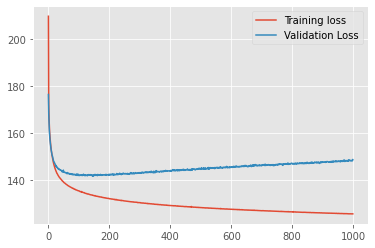

In [12]:
plt.figure()
plt.plot(losses_train, label='Training loss')
plt.plot(losses_val, label='Validation Loss')
plt.legend()
plt.savefig('drive/MyDrive/VAE_outputs/VAEloss.png')